# Siamese Net for Speaker Identification using spectogram images of speech data, leveraging Cross Entropy Loss

In [7]:
! pip uninstall -y pyvis

Found existing installation: pyvis 0.1.8.2
Uninstalling pyvis-0.1.8.2:
  Successfully uninstalled pyvis-0.1.8.2


In [5]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.3.0+cu100
# CUDA enabled: True

Version 1.5.1
CUDA enabled: False


In [6]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [7]:
! pwd

/mnt/c/Users/victor/OneDrive - Universidade Federal do ABC/Mestrado/pesquisa_codigos/You-Only-Speak-Once/spectogram_net


In [8]:
import os
BASE_PATH = '/mnt/c/Users/victor/OneDrive - Universidade Federal do ABC/Mestrado/pesquisa_codigos/You-Only-Speak-Once/spectogram_net'
os.chdir(BASE_PATH)

In [9]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [13]:
!ls 

DR1_mini		      SiameseNet_CrossEntropy_B1.ipynb
feature_extraction	      SiameseNet_CrossEntropy.ipynb
__init__.py		      SiameseNet_CrossEntropy.py
SiameseNet_Contrastive.ipynb  SiameseNet_CrossEntropy_withDropout.ipynb


In [63]:
class Config():
    #base_dir = ""
    training_dir = BASE_PATH + "/train-gram/"
    testing_dir = BASE_PATH + "/train-gram/"
    train_batch_size = 2
    train_number_epochs = 10

# Preprocess Spectrogram

In [33]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os, errno
from pathlib import Path
from glob import glob
import uuid

In [34]:
files = glob('DR1_mini/*/*.wav')

In [25]:
os.makedirs('train-gram')

In [58]:
my_dpi = 120

for index,f in enumerate(files):
    spk = f.split('/')[1]
    os.makedirs(f'train-gram/{spk}',exist_ok=True)
    ay, sr = librosa.load(f)
    sr = 8000
    duration = ay.shape[0] / sr
    start = 0
    while start + 5 < duration:
        slice_ = ay[start * sr: (start + 5) * sr]
        start = start + 5 - 1
        x = librosa.stft(slice_)
        xdb = librosa.amplitude_to_db(abs(x))
        plt.figure(figsize=(227 / my_dpi, 227 / my_dpi), dpi=my_dpi)
        plt.axis('off')
        librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='log')
        plt.savefig('train-gram/' + str(spk) + '/' + uuid.uuid4().hex + '.png', dpi=my_dpi)
        plt.close()

    print('work done on index {}, speaker {}'.format(index, spk))


work done on index 0, speaker 14
work done on index 1, speaker 14
work done on index 2, speaker 14
work done on index 3, speaker 14
work done on index 4, speaker 14
work done on index 5, speaker 14
work done on index 6, speaker 14
work done on index 7, speaker 14
work done on index 8, speaker 14
work done on index 9, speaker 16
work done on index 10, speaker 16
work done on index 11, speaker 16
work done on index 12, speaker 16
work done on index 13, speaker 16
work done on index 14, speaker 16
work done on index 15, speaker 16
work done on index 16, speaker 16
work done on index 17, speaker 19
work done on index 18, speaker 19
work done on index 19, speaker 19
work done on index 20, speaker 19
work done on index 21, speaker 19
work done on index 22, speaker 19
work done on index 23, speaker 19
work done on index 24, speaker 19
work done on index 25, speaker 20
work done on index 26, speaker 20
work done on index 27, speaker 20
work done on index 28, speaker 20
work done on index 29, s

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [64]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        labels = torch.squeeze(torch.from_numpy(np.array([int(img1_tuple[1]==img0_tuple[1])],dtype=np.float32)).long())
        # Label = 1 when the images are from the same class
        return img0, img1 , labels
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [65]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)
kwargs = {'num_workers': num_workers,
          'pin_memory': True} if use_cuda else {}

Using device cpu
num workers: 4


In [66]:
Config.training_dir

'/mnt/c/Users/victor/OneDrive - Universidade Federal do ABC/Mestrado/pesquisa_codigos/You-Only-Speak-Once/spectogram_net/train-gram/'

In [67]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([#transforms.Resize((227,227)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
train_dataloader = DataLoader(siamese_dataset,
                              shuffle=True,
                              batch_size=Config.train_batch_size,
                              **kwargs)

In [101]:
len(DataLoader(siamese_dataset, batch_size=2, shuffle=False, **kwargs))

233

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates samle class, and 0 indicates not the same class.

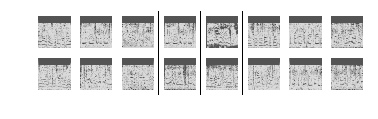

[1 0 1 1 0 0 1 1]


In [68]:
vis_dataloader = DataLoader(siamese_dataset, shuffle=True,         
                            batch_size=8, **kwargs)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [76]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            # nn.ReflectionPad2d(1),
            # nn.Conv2d(8, 8, kernel_size=3),
            # nn.ReLU(inplace=True),
            # nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*227*227, 512),
            nn.ReLU(inplace=True),

            # nn.Linear(512, 128),
            # nn.ReLU(inplace=True)
            )

        self.fc2 = nn.Linear(512, 2)

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return self.fc2(torch.abs(output1 - output2))

## Contrastive Loss

In [77]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [78]:
ContrastiveLoss()

ContrastiveLoss()

## Cross Entropy Loss

In [79]:
class CrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()

    def forward(self, output, label):
        label = label.long()
        #import pdb; pdb.set_trace()
        loss = F.cross_entropy(output, label)
        return loss

## Training Time!

In [80]:
Config.train_batch_size

2

In [81]:
len(train_dataloader)

233

In [82]:
net = SiameseNetwork().to(device)
criterion = CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [83]:
net

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=412232, out_features=512, bias=True)
    (1): ReLU(inplace=True)
  )
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [84]:
counter = []
loss_history = [] 
iteration_number= 0

In [85]:
def train(model, device, train_loader, epoch):
    model.train()
    losses = []
    accurate_labels = 0
    all_labels = 0
    len_train_loader = len(train_loader)
    for batch_idx, (data0, data1, label) in enumerate(tqdm.tqdm(train_loader)): #tqdm.tqdm(train_loader)
        data0, data1, label = data0.to(device), data1.to(device), label.to(device)
        optimizer.zero_grad()
        
        out = model(data0, data1)
        loss_function = criterion(out, label)
        losses.append(loss_function.item())
        loss_function.backward()
        
        optimizer.step()
        
        accurate_labels += torch.sum(torch.argmax(out, dim=1) == label).cpu()
        all_labels += len(label)
            
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTrain Accuracy: {:.6f}'.format(
                epoch, (batch_idx+1) * len(data0), len(train_loader.dataset),
                100. * (batch_idx+1) / len(train_loader), loss_function.item(),
                (100. * accurate_labels / all_labels)))
    train_loss = np.mean(losses)
    train_accuracy = 100. * accurate_labels / all_labels
    print('\nTrain set: Average loss = {:.4f}, Train Accuracy = {:.4f}\n'.format(train_loss, train_accuracy))
    return train_loss, train_accuracy

In [86]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([#transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset, batch_size=256, shuffle=False, **kwargs)

In [87]:
def test(model, device, test_loader):
    model.eval()
    accurate_labels = 0
    all_labels = 0
    losses = []
    with torch.no_grad():
        for batch_idx, (data0, data1, label) in enumerate(tqdm.tqdm(test_loader)):
            data0, data1, label = data0.to(device), data1.to(device), label.to(device)
            out = model(data0, data1)
            #import pdb; pdb.set_trace()
            loss_function = criterion(out, label)
            losses.append(loss_function.item())

            accurate_labels += torch.sum(torch.argmax(out, dim=1) == label).cpu()
            all_labels += len(label)
    test_loss = np.mean(losses)
    test_accuracy = 100. * accurate_labels / all_labels
    print('\nTest set: Average loss = {:.4f}, Test Accuracy = {:.4f}\n'.format(test_loss, test_accuracy))
    return test_loss, test_accuracy

In [88]:
EPOCHS = 50

In [91]:
import tqdm
import time

In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [93]:
len(test_dataloader)

2

In [94]:
len(train_dataloader)

233

In [95]:
test(net, device, test_dataloader)

100%|██████████| 2/2 [00:22<00:00, 11.28s/it]


Test set: Average loss = 0.6933, Test Accuracy = 49.6774



(0.6933451890945435, tensor(49.6774))

In [0]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(0, EPOCHS):
    print("Epoch number: ", epoch)
    #lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
    start_time = time.time()
    print("\nTraining:")
    train_loss, train_accuracy = train(net, device, train_dataloader, epoch)
    print("\nTesting:")
    test_loss, test_accuracy = test(net, device, test_dataloader)
    train_losses.append((epoch, train_loss))
    test_losses.append((epoch, test_loss))
    train_accuracies.append((epoch, train_accuracy))
    test_accuracies.append((epoch, test_accuracy))
    torch.save(net.state_dict(), 'siamese_net_crossEntropy.pt')
    end_time = time.time()
    print("Time taken for running epoch {} is {:.3f} seconds.\n\n".format(epoch, end_time-start_time))

  0%|          | 0/215 [00:00<?, ?it/s]

Epoch number:  0

Training:


  0%|          | 1/215 [03:20<11:54:06, 200.22s/it]

Train Epoch: 0 [256/54863 (0%)]	Loss: 0.701044	Train Accuracy: 51.171875


 10%|▉         | 21/215 [29:27<4:27:10, 82.63s/it]

Train Epoch: 0 [5376/54863 (10%)]	Loss: 3.231353	Train Accuracy: 61.421131


 19%|█▉        | 41/215 [51:01<3:32:17, 73.20s/it]

Train Epoch: 0 [10496/54863 (19%)]	Loss: 2.224010	Train Accuracy: 63.567074


 28%|██▊       | 61/215 [1:08:49<2:32:12, 59.30s/it]

Train Epoch: 0 [15616/54863 (28%)]	Loss: 0.859614	Train Accuracy: 65.573769


 38%|███▊      | 81/215 [1:23:14<1:45:19, 47.16s/it]

Train Epoch: 0 [20736/54863 (38%)]	Loss: 0.759258	Train Accuracy: 67.211609


 47%|████▋     | 101/215 [1:35:21<1:15:31, 39.75s/it]

Train Epoch: 0 [25856/54863 (47%)]	Loss: 0.612861	Train Accuracy: 68.537285


 56%|█████▋    | 121/215 [1:45:27<52:38, 33.60s/it]

Train Epoch: 0 [30976/54863 (56%)]	Loss: 0.522496	Train Accuracy: 69.983215


 66%|██████▌   | 141/215 [1:54:03<34:13, 27.75s/it]

Train Epoch: 0 [36096/54863 (66%)]	Loss: 0.391625	Train Accuracy: 71.395721


 75%|███████▍  | 161/215 [2:01:36<21:25, 23.81s/it]

Train Epoch: 0 [41216/54863 (75%)]	Loss: 0.516778	Train Accuracy: 72.726608


 84%|████████▍ | 181/215 [2:07:59<11:27, 20.22s/it]

Train Epoch: 0 [46336/54863 (84%)]	Loss: 0.365414	Train Accuracy: 73.836754


 93%|█████████▎| 201/215 [2:13:14<03:53, 16.65s/it]

Train Epoch: 0 [51456/54863 (93%)]	Loss: 0.351161	Train Accuracy: 74.821205


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 1.3348, Train Accuracy = 75.3969


Testing:


100%|██████████| 55/55 [34:39<00:00, 37.81s/it]



Test set: Average loss = 0.5135, Test Accuracy = 78.3876



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 0 is 10236.168 seconds.


Epoch number:  1

Training:


  0%|          | 1/215 [00:28<1:40:28, 28.17s/it]

Train Epoch: 1 [256/54863 (0%)]	Loss: 0.290471	Train Accuracy: 87.500000


 10%|▉         | 21/215 [04:19<36:55, 11.42s/it]

Train Epoch: 1 [5376/54863 (10%)]	Loss: 0.335392	Train Accuracy: 85.342262


 19%|█▉        | 41/215 [07:34<23:11,  8.00s/it]

Train Epoch: 1 [10496/54863 (19%)]	Loss: 0.334344	Train Accuracy: 85.489708


 28%|██▊       | 61/215 [10:20<17:49,  6.94s/it]

Train Epoch: 1 [15616/54863 (28%)]	Loss: 0.276616	Train Accuracy: 85.495644


 38%|███▊      | 81/215 [12:46<14:41,  6.58s/it]

Train Epoch: 1 [20736/54863 (38%)]	Loss: 0.337728	Train Accuracy: 85.667435


 47%|████▋     | 101/215 [14:48<10:58,  5.77s/it]

Train Epoch: 1 [25856/54863 (47%)]	Loss: 0.364119	Train Accuracy: 85.829208


 56%|█████▋    | 121/215 [16:52<06:56,  4.43s/it]

Train Epoch: 1 [30976/54863 (56%)]	Loss: 0.266493	Train Accuracy: 85.818054


 66%|██████▌   | 141/215 [18:31<05:27,  4.43s/it]

Train Epoch: 1 [36096/54863 (66%)]	Loss: 0.263538	Train Accuracy: 85.973518


 75%|███████▍  | 161/215 [19:50<03:03,  3.40s/it]

Train Epoch: 1 [41216/54863 (75%)]	Loss: 0.334007	Train Accuracy: 86.172844


 84%|████████▍ | 181/215 [21:01<01:57,  3.47s/it]

Train Epoch: 1 [46336/54863 (84%)]	Loss: 0.265939	Train Accuracy: 86.336754


 93%|█████████▎| 201/215 [22:04<00:42,  3.07s/it]

Train Epoch: 1 [51456/54863 (93%)]	Loss: 0.294000	Train Accuracy: 86.450562


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.3246, Train Accuracy = 86.5647


Testing:


100%|██████████| 55/55 [05:44<00:00,  6.26s/it]



Test set: Average loss = 0.5280, Test Accuracy = 80.8532



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 1 is 1714.207 seconds.


Epoch number:  2

Training:


  0%|          | 1/215 [00:07<28:18,  7.94s/it]

Train Epoch: 2 [256/54863 (0%)]	Loss: 0.325105	Train Accuracy: 86.718750


 10%|▉         | 21/215 [01:09<09:30,  2.94s/it]

Train Epoch: 2 [5376/54863 (10%)]	Loss: 0.321361	Train Accuracy: 87.537201


 19%|█▉        | 41/215 [02:03<07:45,  2.68s/it]

Train Epoch: 2 [10496/54863 (19%)]	Loss: 0.237743	Train Accuracy: 87.957314


 28%|██▊       | 61/215 [02:57<06:38,  2.58s/it]

Train Epoch: 2 [15616/54863 (28%)]	Loss: 0.364173	Train Accuracy: 88.230019


 38%|███▊      | 81/215 [03:42<04:52,  2.18s/it]

Train Epoch: 2 [20736/54863 (38%)]	Loss: 0.281983	Train Accuracy: 88.387344


 47%|████▋     | 101/215 [04:29<04:25,  2.33s/it]

Train Epoch: 2 [25856/54863 (47%)]	Loss: 0.278942	Train Accuracy: 88.590652


 56%|█████▋    | 121/215 [05:18<03:57,  2.53s/it]

Train Epoch: 2 [30976/54863 (56%)]	Loss: 0.280247	Train Accuracy: 88.665421


 66%|██████▌   | 141/215 [05:58<02:28,  2.01s/it]

Train Epoch: 2 [36096/54863 (66%)]	Loss: 0.321508	Train Accuracy: 88.671875


 75%|███████▍  | 161/215 [06:40<02:03,  2.29s/it]

Train Epoch: 2 [41216/54863 (75%)]	Loss: 0.209545	Train Accuracy: 88.727676


 84%|████████▍ | 181/215 [07:19<01:04,  1.88s/it]

Train Epoch: 2 [46336/54863 (84%)]	Loss: 0.304656	Train Accuracy: 88.730148


 93%|█████████▎| 201/215 [07:56<00:25,  1.80s/it]

Train Epoch: 2 [51456/54863 (93%)]	Loss: 0.308561	Train Accuracy: 88.848724


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.2827, Train Accuracy = 88.8741


Testing:


100%|██████████| 55/55 [01:51<00:00,  2.02s/it]



Test set: Average loss = 0.5616, Test Accuracy = 81.4678



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 2 is 617.124 seconds.


Epoch number:  3

Training:


  0%|          | 1/215 [00:05<17:56,  5.03s/it]

Train Epoch: 3 [256/54863 (0%)]	Loss: 0.304283	Train Accuracy: 88.281250


 10%|▉         | 21/215 [00:47<06:25,  1.99s/it]

Train Epoch: 3 [5376/54863 (10%)]	Loss: 0.273944	Train Accuracy: 89.825150


 19%|█▉        | 41/215 [01:28<05:43,  1.97s/it]

Train Epoch: 3 [10496/54863 (19%)]	Loss: 0.211078	Train Accuracy: 89.853279


 28%|██▊       | 61/215 [02:08<05:05,  1.98s/it]

Train Epoch: 3 [15616/54863 (28%)]	Loss: 0.336167	Train Accuracy: 90.221565


 38%|███▊      | 81/215 [02:48<04:06,  1.84s/it]

Train Epoch: 3 [20736/54863 (38%)]	Loss: 0.212841	Train Accuracy: 90.499611


 47%|████▋     | 101/215 [03:27<03:43,  1.96s/it]

Train Epoch: 3 [25856/54863 (47%)]	Loss: 0.234489	Train Accuracy: 90.659805


 56%|█████▋    | 121/215 [04:04<03:02,  1.94s/it]

Train Epoch: 3 [30976/54863 (56%)]	Loss: 0.264090	Train Accuracy: 90.602402


 66%|██████▌   | 141/215 [04:42<02:29,  2.02s/it]

Train Epoch: 3 [36096/54863 (66%)]	Loss: 0.213623	Train Accuracy: 90.605606


 75%|███████▍  | 161/215 [05:19<01:38,  1.82s/it]

Train Epoch: 3 [41216/54863 (75%)]	Loss: 0.239315	Train Accuracy: 90.649261


 84%|████████▍ | 181/215 [05:56<01:03,  1.87s/it]

Train Epoch: 3 [46336/54863 (84%)]	Loss: 0.331392	Train Accuracy: 90.625000


 93%|█████████▎| 201/215 [06:30<00:24,  1.74s/it]

Train Epoch: 3 [51456/54863 (93%)]	Loss: 0.206228	Train Accuracy: 90.582245


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.2379, Train Accuracy = 90.6677


Testing:


100%|██████████| 55/55 [01:29<00:00,  1.62s/it]



Test set: Average loss = 0.5594, Test Accuracy = 82.0390



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 3 is 507.622 seconds.


Epoch number:  4

Training:


  0%|          | 1/215 [00:05<19:31,  5.47s/it]

Train Epoch: 4 [256/54863 (0%)]	Loss: 0.151786	Train Accuracy: 95.312500


 10%|▉         | 21/215 [00:46<06:37,  2.05s/it]

Train Epoch: 4 [5376/54863 (10%)]	Loss: 0.231355	Train Accuracy: 91.350449


 19%|█▉        | 41/215 [01:25<05:34,  1.92s/it]

Train Epoch: 4 [10496/54863 (19%)]	Loss: 0.218345	Train Accuracy: 91.291924


 28%|██▊       | 61/215 [02:04<04:50,  1.89s/it]

Train Epoch: 4 [15616/54863 (28%)]	Loss: 0.202255	Train Accuracy: 91.387039


 38%|███▊      | 81/215 [02:42<04:05,  1.83s/it]

Train Epoch: 4 [20736/54863 (38%)]	Loss: 0.258800	Train Accuracy: 91.589508


 47%|████▋     | 101/215 [03:19<03:26,  1.81s/it]

Train Epoch: 4 [25856/54863 (47%)]	Loss: 0.275579	Train Accuracy: 91.533882


 56%|█████▋    | 121/215 [03:57<02:55,  1.86s/it]

Train Epoch: 4 [30976/54863 (56%)]	Loss: 0.202247	Train Accuracy: 91.467590


 66%|██████▌   | 141/215 [04:33<02:11,  1.77s/it]

Train Epoch: 4 [36096/54863 (66%)]	Loss: 0.240530	Train Accuracy: 91.469971


 75%|███████▍  | 161/215 [05:10<01:33,  1.74s/it]

Train Epoch: 4 [41216/54863 (75%)]	Loss: 0.300874	Train Accuracy: 91.515434


 84%|████████▍ | 181/215 [05:45<01:00,  1.77s/it]

Train Epoch: 4 [46336/54863 (84%)]	Loss: 0.237736	Train Accuracy: 91.326401


 93%|█████████▎| 201/215 [06:22<00:24,  1.78s/it]

Train Epoch: 4 [51456/54863 (93%)]	Loss: 0.176825	Train Accuracy: 91.396530


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.2267, Train Accuracy = 91.4314


Testing:


100%|██████████| 55/55 [01:26<00:00,  1.58s/it]



Test set: Average loss = 0.5844, Test Accuracy = 82.1258



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 4 is 496.620 seconds.


Epoch number:  5

Training:


  0%|          | 1/215 [00:05<18:37,  5.22s/it]

Train Epoch: 5 [256/54863 (0%)]	Loss: 0.210613	Train Accuracy: 91.015625


 10%|▉         | 21/215 [00:46<06:21,  1.97s/it]

Train Epoch: 5 [5376/54863 (10%)]	Loss: 0.163488	Train Accuracy: 91.964287


 19%|█▉        | 41/215 [01:25<05:58,  2.06s/it]

Train Epoch: 5 [10496/54863 (19%)]	Loss: 0.254854	Train Accuracy: 91.072792


 28%|██▊       | 61/215 [02:04<05:14,  2.04s/it]

Train Epoch: 5 [15616/54863 (28%)]	Loss: 0.233552	Train Accuracy: 90.983604


 38%|███▊      | 81/215 [02:43<04:31,  2.03s/it]

Train Epoch: 5 [20736/54863 (38%)]	Loss: 0.199016	Train Accuracy: 91.290512


 47%|████▋     | 101/215 [03:21<03:38,  1.92s/it]

Train Epoch: 5 [25856/54863 (47%)]	Loss: 0.158324	Train Accuracy: 91.448792


 56%|█████▋    | 121/215 [03:59<02:57,  1.88s/it]

Train Epoch: 5 [30976/54863 (56%)]	Loss: 0.185705	Train Accuracy: 91.593491


 66%|██████▌   | 141/215 [04:36<02:21,  1.92s/it]

Train Epoch: 5 [36096/54863 (66%)]	Loss: 0.207221	Train Accuracy: 91.594635


 75%|███████▍  | 161/215 [05:13<01:41,  1.88s/it]

Train Epoch: 5 [41216/54863 (75%)]	Loss: 0.121153	Train Accuracy: 91.772614


 84%|████████▍ | 181/215 [05:49<01:03,  1.87s/it]

Train Epoch: 5 [46336/54863 (84%)]	Loss: 0.207673	Train Accuracy: 91.814140


 93%|█████████▎| 201/215 [06:25<00:26,  1.90s/it]

Train Epoch: 5 [51456/54863 (93%)]	Loss: 0.239062	Train Accuracy: 91.824081


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.2168, Train Accuracy = 91.8925


Testing:


100%|██████████| 55/55 [01:25<00:00,  1.56s/it]



Test set: Average loss = 0.6879, Test Accuracy = 82.0607



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 5 is 499.714 seconds.


Epoch number:  6

Training:


  0%|          | 1/215 [00:05<18:30,  5.19s/it]

Train Epoch: 6 [256/54863 (0%)]	Loss: 0.213466	Train Accuracy: 92.187500


 10%|▉         | 21/215 [00:46<06:36,  2.04s/it]

Train Epoch: 6 [5376/54863 (10%)]	Loss: 0.638511	Train Accuracy: 88.169640


 19%|█▉        | 41/215 [01:26<05:53,  2.03s/it]

Train Epoch: 6 [10496/54863 (19%)]	Loss: 0.264440	Train Accuracy: 89.643677


 28%|██▊       | 61/215 [02:05<05:02,  1.97s/it]

Train Epoch: 6 [15616/54863 (28%)]	Loss: 0.191185	Train Accuracy: 90.298409


 38%|███▊      | 81/215 [02:44<04:26,  1.99s/it]

Train Epoch: 6 [20736/54863 (38%)]	Loss: 0.179311	Train Accuracy: 90.832367


 47%|████▋     | 101/215 [03:22<03:38,  1.92s/it]

Train Epoch: 6 [25856/54863 (47%)]	Loss: 0.229962	Train Accuracy: 90.992416


 56%|█████▋    | 121/215 [03:59<02:59,  1.91s/it]

Train Epoch: 6 [30976/54863 (56%)]	Loss: 0.223161	Train Accuracy: 91.170586


 66%|██████▌   | 141/215 [04:36<02:21,  1.91s/it]

Train Epoch: 6 [36096/54863 (66%)]	Loss: 0.271351	Train Accuracy: 91.342529


 75%|███████▍  | 161/215 [05:13<01:40,  1.87s/it]

Train Epoch: 6 [41216/54863 (75%)]	Loss: 0.227124	Train Accuracy: 91.563957


 84%|████████▍ | 181/215 [05:50<01:03,  1.88s/it]

Train Epoch: 6 [46336/54863 (84%)]	Loss: 0.156256	Train Accuracy: 91.766663


 93%|█████████▎| 201/215 [06:26<00:26,  1.86s/it]

Train Epoch: 6 [51456/54863 (93%)]	Loss: 0.250224	Train Accuracy: 91.917366


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.2219, Train Accuracy = 91.9891


Testing:


100%|██████████| 55/55 [01:26<00:00,  1.57s/it]



Test set: Average loss = 0.6658, Test Accuracy = 81.7281



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 6 is 499.733 seconds.


Epoch number:  7

Training:


  0%|          | 1/215 [00:05<18:54,  5.30s/it]

Train Epoch: 7 [256/54863 (0%)]	Loss: 0.189585	Train Accuracy: 91.796875


 10%|▉         | 21/215 [00:46<06:35,  2.04s/it]

Train Epoch: 7 [5376/54863 (10%)]	Loss: 0.240325	Train Accuracy: 93.563988


 19%|█▉        | 41/215 [01:25<05:53,  2.03s/it]

Train Epoch: 7 [10496/54863 (19%)]	Loss: 0.200548	Train Accuracy: 92.959221


 28%|██▊       | 61/215 [02:05<05:14,  2.04s/it]

Train Epoch: 7 [15616/54863 (28%)]	Loss: 0.177769	Train Accuracy: 92.866287


 38%|███▊      | 81/215 [02:44<04:32,  2.03s/it]

Train Epoch: 7 [20736/54863 (38%)]	Loss: 0.196975	Train Accuracy: 93.079666


 47%|████▋     | 101/215 [03:22<03:45,  1.98s/it]

Train Epoch: 7 [25856/54863 (47%)]	Loss: 0.185240	Train Accuracy: 93.073174


 56%|█████▋    | 121/215 [04:00<03:02,  1.94s/it]

Train Epoch: 7 [30976/54863 (56%)]	Loss: 0.180983	Train Accuracy: 93.149536


 66%|██████▌   | 141/215 [04:37<02:17,  1.86s/it]

Train Epoch: 7 [36096/54863 (66%)]	Loss: 0.152034	Train Accuracy: 93.279037


 75%|███████▍  | 161/215 [05:13<01:42,  1.90s/it]

Train Epoch: 7 [41216/54863 (75%)]	Loss: 0.164887	Train Accuracy: 93.371506


 84%|████████▍ | 181/215 [05:50<01:05,  1.91s/it]

Train Epoch: 7 [46336/54863 (84%)]	Loss: 0.193172	Train Accuracy: 93.376640


 93%|█████████▎| 201/215 [06:26<00:26,  1.88s/it]

Train Epoch: 7 [51456/54863 (93%)]	Loss: 0.118442	Train Accuracy: 93.421562


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.1776, Train Accuracy = 93.4473


Testing:


100%|██████████| 55/55 [01:26<00:00,  1.58s/it]



Test set: Average loss = 0.7404, Test Accuracy = 82.7187



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 7 is 501.882 seconds.


Epoch number:  8

Training:


  0%|          | 1/215 [00:04<17:47,  4.99s/it]

Train Epoch: 8 [256/54863 (0%)]	Loss: 0.210335	Train Accuracy: 93.359375


 10%|▉         | 21/215 [00:47<06:46,  2.09s/it]

Train Epoch: 8 [5376/54863 (10%)]	Loss: 0.222846	Train Accuracy: 93.377975


 19%|█▉        | 41/215 [01:27<06:02,  2.08s/it]

Train Epoch: 8 [10496/54863 (19%)]	Loss: 0.204984	Train Accuracy: 93.426064


 28%|██▊       | 61/215 [02:07<05:17,  2.06s/it]

Train Epoch: 8 [15616/54863 (28%)]	Loss: 0.167355	Train Accuracy: 93.455429


 38%|███▊      | 81/215 [02:45<04:31,  2.03s/it]

Train Epoch: 8 [20736/54863 (38%)]	Loss: 0.155382	Train Accuracy: 93.634262


 47%|████▋     | 101/215 [03:24<03:47,  2.00s/it]

Train Epoch: 8 [25856/54863 (47%)]	Loss: 0.249739	Train Accuracy: 93.541153


 56%|█████▋    | 121/215 [04:01<03:02,  1.94s/it]

Train Epoch: 8 [30976/54863 (56%)]	Loss: 0.176069	Train Accuracy: 93.485275


 66%|██████▌   | 141/215 [04:38<02:20,  1.89s/it]

Train Epoch: 8 [36096/54863 (66%)]	Loss: 0.139646	Train Accuracy: 93.641953


 75%|███████▍  | 161/215 [05:15<01:41,  1.88s/it]

Train Epoch: 8 [41216/54863 (75%)]	Loss: 0.118506	Train Accuracy: 93.662659


 84%|████████▍ | 181/215 [05:51<01:05,  1.93s/it]

Train Epoch: 8 [46336/54863 (84%)]	Loss: 0.117760	Train Accuracy: 93.708992


 93%|█████████▎| 201/215 [06:28<00:26,  1.88s/it]

Train Epoch: 8 [51456/54863 (93%)]	Loss: 0.139571	Train Accuracy: 93.779152


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.1658, Train Accuracy = 93.8356


Testing:


100%|██████████| 55/55 [01:27<00:00,  1.60s/it]



Test set: Average loss = 0.7675, Test Accuracy = 82.5886



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 8 is 504.524 seconds.


Epoch number:  9

Training:


  0%|          | 1/215 [00:05<18:40,  5.23s/it]

Train Epoch: 9 [256/54863 (0%)]	Loss: 0.227705	Train Accuracy: 92.187500


 10%|▉         | 21/215 [00:47<06:47,  2.10s/it]

Train Epoch: 9 [5376/54863 (10%)]	Loss: 0.236992	Train Accuracy: 94.066223


 19%|█▉        | 41/215 [01:27<06:10,  2.13s/it]

Train Epoch: 9 [10496/54863 (19%)]	Loss: 0.136643	Train Accuracy: 94.674164


 28%|██▊       | 61/215 [02:08<05:24,  2.11s/it]

Train Epoch: 9 [15616/54863 (28%)]	Loss: 0.239720	Train Accuracy: 94.422386


 38%|███▊      | 81/215 [02:47<04:29,  2.01s/it]

Train Epoch: 9 [20736/54863 (38%)]	Loss: 0.102527	Train Accuracy: 94.352814


 47%|████▋     | 101/215 [03:26<03:46,  1.99s/it]

Train Epoch: 9 [25856/54863 (47%)]	Loss: 0.115548	Train Accuracy: 94.287590


 56%|█████▋    | 121/215 [04:04<03:05,  1.98s/it]

Train Epoch: 9 [30976/54863 (56%)]	Loss: 0.144300	Train Accuracy: 94.334320


 66%|██████▌   | 141/215 [04:42<02:18,  1.87s/it]

Train Epoch: 9 [36096/54863 (66%)]	Loss: 0.165907	Train Accuracy: 94.434288


 75%|███████▍  | 161/215 [05:19<01:45,  1.96s/it]

Train Epoch: 9 [41216/54863 (75%)]	Loss: 0.218706	Train Accuracy: 94.451187


 84%|████████▍ | 181/215 [05:56<01:03,  1.86s/it]

Train Epoch: 9 [46336/54863 (84%)]	Loss: 0.166959	Train Accuracy: 94.444923


 93%|█████████▎| 201/215 [06:33<00:26,  1.86s/it]

Train Epoch: 9 [51456/54863 (93%)]	Loss: 0.134461	Train Accuracy: 94.529305


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.1503, Train Accuracy = 94.5373


Testing:


100%|██████████| 55/55 [01:27<00:00,  1.59s/it]



Test set: Average loss = 0.6285, Test Accuracy = 82.8344



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 9 is 508.389 seconds.


Epoch number:  10

Training:


  0%|          | 1/215 [00:05<18:40,  5.24s/it]

Train Epoch: 10 [256/54863 (0%)]	Loss: 0.203263	Train Accuracy: 92.187500


 10%|▉         | 21/215 [00:47<06:45,  2.09s/it]

Train Epoch: 10 [5376/54863 (10%)]	Loss: 0.112874	Train Accuracy: 94.401039


 19%|█▉        | 41/215 [01:28<05:48,  2.00s/it]

Train Epoch: 10 [10496/54863 (19%)]	Loss: 0.202120	Train Accuracy: 94.683685


 28%|██▊       | 61/215 [02:07<05:13,  2.03s/it]

Train Epoch: 10 [15616/54863 (28%)]	Loss: 0.165563	Train Accuracy: 94.889854


 38%|███▊      | 81/215 [02:46<04:27,  2.00s/it]

Train Epoch: 10 [20736/54863 (38%)]	Loss: 0.141254	Train Accuracy: 94.883293


 47%|████▋     | 101/215 [03:25<03:44,  1.97s/it]

Train Epoch: 10 [25856/54863 (47%)]	Loss: 0.153118	Train Accuracy: 94.902534


 56%|█████▋    | 121/215 [04:02<03:00,  1.92s/it]

Train Epoch: 10 [30976/54863 (56%)]	Loss: 0.064054	Train Accuracy: 94.873451


 66%|██████▌   | 141/215 [04:40<02:21,  1.91s/it]

Train Epoch: 10 [36096/54863 (66%)]	Loss: 0.168894	Train Accuracy: 94.927414


 75%|███████▍  | 161/215 [05:16<01:37,  1.81s/it]

Train Epoch: 10 [41216/54863 (75%)]	Loss: 0.095933	Train Accuracy: 94.829681


 84%|████████▍ | 181/215 [05:52<01:01,  1.81s/it]

Train Epoch: 10 [46336/54863 (84%)]	Loss: 0.154784	Train Accuracy: 94.820442


 93%|█████████▎| 201/215 [06:28<00:26,  1.87s/it]

Train Epoch: 10 [51456/54863 (93%)]	Loss: 0.163038	Train Accuracy: 94.768349


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.1438, Train Accuracy = 94.7469


Testing:


100%|██████████| 55/55 [01:25<00:00,  1.56s/it]



Test set: Average loss = 0.7566, Test Accuracy = 83.0224



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 10 is 502.718 seconds.


Epoch number:  11

Training:


  0%|          | 1/215 [00:05<18:28,  5.18s/it]

Train Epoch: 11 [256/54863 (0%)]	Loss: 0.146576	Train Accuracy: 94.140625


 10%|▉         | 21/215 [00:46<06:54,  2.14s/it]

Train Epoch: 11 [5376/54863 (10%)]	Loss: 0.177648	Train Accuracy: 94.010414


 19%|█▉        | 41/215 [01:26<06:02,  2.08s/it]

Train Epoch: 11 [10496/54863 (19%)]	Loss: 0.133040	Train Accuracy: 94.378815


 28%|██▊       | 61/215 [02:06<05:18,  2.07s/it]

Train Epoch: 11 [15616/54863 (28%)]	Loss: 0.171422	Train Accuracy: 94.300720


 38%|███▊      | 81/215 [02:44<04:27,  1.99s/it]

Train Epoch: 11 [20736/54863 (38%)]	Loss: 0.112491	Train Accuracy: 94.463737


 47%|████▋     | 101/215 [03:23<03:44,  1.97s/it]

Train Epoch: 11 [25856/54863 (47%)]	Loss: 0.135650	Train Accuracy: 94.566055


 56%|█████▋    | 121/215 [04:00<02:56,  1.88s/it]

Train Epoch: 11 [30976/54863 (56%)]	Loss: 0.159990	Train Accuracy: 94.608727


 66%|██████▌   | 141/215 [04:38<02:23,  1.94s/it]

Train Epoch: 11 [36096/54863 (66%)]	Loss: 0.117459	Train Accuracy: 94.703011


 75%|███████▍  | 161/215 [05:14<01:40,  1.87s/it]

Train Epoch: 11 [41216/54863 (75%)]	Loss: 0.090364	Train Accuracy: 94.805412


 84%|████████▍ | 181/215 [05:50<01:01,  1.81s/it]

Train Epoch: 11 [46336/54863 (84%)]	Loss: 0.113765	Train Accuracy: 94.803177


 93%|█████████▎| 201/215 [06:26<00:25,  1.81s/it]

Train Epoch: 11 [51456/54863 (93%)]	Loss: 0.119808	Train Accuracy: 94.853859


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.1401, Train Accuracy = 94.8909


Testing:


100%|██████████| 55/55 [01:26<00:00,  1.57s/it]



Test set: Average loss = 0.9019, Test Accuracy = 80.7520



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 11 is 499.919 seconds.


Epoch number:  12

Training:


  0%|          | 1/215 [00:05<18:27,  5.18s/it]

Train Epoch: 12 [256/54863 (0%)]	Loss: 0.146602	Train Accuracy: 93.359375


 10%|▉         | 21/215 [00:46<06:38,  2.05s/it]

Train Epoch: 12 [5376/54863 (10%)]	Loss: 0.123577	Train Accuracy: 94.642860


 19%|█▉        | 41/215 [01:26<05:57,  2.05s/it]

Train Epoch: 12 [10496/54863 (19%)]	Loss: 0.167716	Train Accuracy: 94.836128


 28%|██▊       | 61/215 [02:05<05:09,  2.01s/it]

Train Epoch: 12 [15616/54863 (28%)]	Loss: 0.094582	Train Accuracy: 94.909065


 38%|███▊      | 81/215 [02:44<04:26,  1.99s/it]

Train Epoch: 12 [20736/54863 (38%)]	Loss: 0.150458	Train Accuracy: 95.052086


 47%|████▋     | 101/215 [03:22<03:47,  1.99s/it]

Train Epoch: 12 [25856/54863 (47%)]	Loss: 0.124936	Train Accuracy: 95.146194


 56%|█████▋    | 121/215 [03:59<02:59,  1.91s/it]

Train Epoch: 12 [30976/54863 (56%)]	Loss: 0.160245	Train Accuracy: 95.199509


 66%|██████▌   | 141/215 [04:36<02:18,  1.87s/it]

Train Epoch: 12 [36096/54863 (66%)]	Loss: 0.163043	Train Accuracy: 95.132423


 75%|███████▍  | 161/215 [05:13<01:41,  1.88s/it]

Train Epoch: 12 [41216/54863 (75%)]	Loss: 0.167815	Train Accuracy: 95.132957


 84%|████████▍ | 181/215 [05:50<01:02,  1.85s/it]

Train Epoch: 12 [46336/54863 (84%)]	Loss: 0.133663	Train Accuracy: 95.170059


 93%|█████████▎| 201/215 [06:26<00:25,  1.82s/it]

Train Epoch: 12 [51456/54863 (93%)]	Loss: 0.233060	Train Accuracy: 95.190063


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.1326, Train Accuracy = 95.1953


Testing:


100%|██████████| 55/55 [01:27<00:00,  1.59s/it]



Test set: Average loss = 0.8769, Test Accuracy = 80.7231



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 12 is 501.533 seconds.


Epoch number:  13

Training:


  0%|          | 1/215 [00:05<18:00,  5.05s/it]

Train Epoch: 13 [256/54863 (0%)]	Loss: 0.149662	Train Accuracy: 93.359375


 10%|▉         | 21/215 [00:46<06:33,  2.03s/it]

Train Epoch: 13 [5376/54863 (10%)]	Loss: 0.107504	Train Accuracy: 95.703125


 19%|█▉        | 41/215 [01:26<05:56,  2.05s/it]

Train Epoch: 13 [10496/54863 (19%)]	Loss: 0.086967	Train Accuracy: 95.560211


 28%|██▊       | 61/215 [02:06<05:17,  2.06s/it]

Train Epoch: 13 [15616/54863 (28%)]	Loss: 0.132774	Train Accuracy: 95.312500


 38%|███▊      | 81/215 [02:45<04:23,  1.96s/it]

Train Epoch: 13 [20736/54863 (38%)]	Loss: 0.103210	Train Accuracy: 95.370369


 47%|████▋     | 101/215 [03:23<03:36,  1.90s/it]

Train Epoch: 13 [25856/54863 (47%)]	Loss: 0.099207	Train Accuracy: 95.362778


 56%|█████▋    | 121/215 [04:01<03:04,  1.96s/it]

Train Epoch: 13 [30976/54863 (56%)]	Loss: 0.118636	Train Accuracy: 95.409348


 66%|██████▌   | 141/215 [04:38<02:19,  1.88s/it]

Train Epoch: 13 [36096/54863 (66%)]	Loss: 0.209625	Train Accuracy: 95.437164


 75%|███████▍  | 161/215 [05:15<01:36,  1.80s/it]

Train Epoch: 13 [41216/54863 (75%)]	Loss: 0.077758	Train Accuracy: 95.521156


 84%|████████▍ | 181/215 [05:52<01:00,  1.79s/it]

Train Epoch: 13 [46336/54863 (84%)]	Loss: 0.114952	Train Accuracy: 95.549896


 93%|█████████▎| 201/215 [06:28<00:24,  1.74s/it]

Train Epoch: 13 [51456/54863 (93%)]	Loss: 0.102230	Train Accuracy: 95.574860


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.1241, Train Accuracy = 95.5835


Testing:


100%|██████████| 55/55 [01:27<00:00,  1.59s/it]



Test set: Average loss = 0.9223, Test Accuracy = 82.0318



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 13 is 503.979 seconds.


Epoch number:  14

Training:


  0%|          | 1/215 [00:05<18:29,  5.18s/it]

Train Epoch: 14 [256/54863 (0%)]	Loss: 0.210102	Train Accuracy: 95.312500


 10%|▉         | 21/215 [00:46<06:38,  2.05s/it]

Train Epoch: 14 [5376/54863 (10%)]	Loss: 0.145031	Train Accuracy: 95.275299


 19%|█▉        | 41/215 [01:26<05:59,  2.07s/it]

Train Epoch: 14 [10496/54863 (19%)]	Loss: 0.159044	Train Accuracy: 95.264862


 28%|██▊       | 61/215 [02:05<05:09,  2.01s/it]

Train Epoch: 14 [15616/54863 (28%)]	Loss: 0.123634	Train Accuracy: 95.344521


 38%|███▊      | 81/215 [02:43<04:24,  1.98s/it]

Train Epoch: 14 [20736/54863 (38%)]	Loss: 0.166654	Train Accuracy: 95.269096


 47%|████▋     | 101/215 [03:21<03:41,  1.94s/it]

Train Epoch: 14 [25856/54863 (47%)]	Loss: 0.133980	Train Accuracy: 95.385986


 56%|█████▋    | 121/215 [03:58<02:59,  1.91s/it]

Train Epoch: 14 [30976/54863 (56%)]	Loss: 0.081340	Train Accuracy: 95.502968


 66%|██████▌   | 141/215 [04:35<02:18,  1.87s/it]

Train Epoch: 14 [36096/54863 (66%)]	Loss: 0.074328	Train Accuracy: 95.523048


 75%|███████▍  | 161/215 [05:13<01:42,  1.89s/it]

Train Epoch: 14 [41216/54863 (75%)]	Loss: 0.069295	Train Accuracy: 95.589088


 84%|████████▍ | 181/215 [05:50<01:03,  1.85s/it]

Train Epoch: 14 [46336/54863 (84%)]	Loss: 0.072556	Train Accuracy: 95.655647


 93%|█████████▎| 201/215 [06:26<00:25,  1.85s/it]

Train Epoch: 14 [51456/54863 (93%)]	Loss: 0.133470	Train Accuracy: 95.652596


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.1229, Train Accuracy = 95.6273


Testing:


100%|██████████| 55/55 [01:28<00:00,  1.60s/it]



Test set: Average loss = 0.6773, Test Accuracy = 84.2733



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 14 is 502.525 seconds.


Epoch number:  15

Training:


  0%|          | 1/215 [00:05<18:18,  5.13s/it]

Train Epoch: 15 [256/54863 (0%)]	Loss: 0.070347	Train Accuracy: 97.265625


 10%|▉         | 21/215 [00:47<06:49,  2.11s/it]

Train Epoch: 15 [5376/54863 (10%)]	Loss: 0.188480	Train Accuracy: 95.145088


 19%|█▉        | 41/215 [01:27<06:05,  2.10s/it]

Train Epoch: 15 [10496/54863 (19%)]	Loss: 0.087502	Train Accuracy: 94.836128


 28%|██▊       | 61/215 [02:07<05:24,  2.11s/it]

Train Epoch: 15 [15616/54863 (28%)]	Loss: 0.159212	Train Accuracy: 95.165215


 38%|███▊      | 81/215 [02:45<04:25,  1.98s/it]

Train Epoch: 15 [20736/54863 (38%)]	Loss: 0.154949	Train Accuracy: 95.331787


 47%|████▋     | 101/215 [03:24<03:48,  2.00s/it]

Train Epoch: 15 [25856/54863 (47%)]	Loss: 0.111210	Train Accuracy: 95.119118


 56%|█████▋    | 121/215 [04:01<03:02,  1.94s/it]

Train Epoch: 15 [30976/54863 (56%)]	Loss: 0.159960	Train Accuracy: 95.180138


 66%|██████▌   | 141/215 [04:39<02:24,  1.95s/it]

Train Epoch: 15 [36096/54863 (66%)]	Loss: 0.104097	Train Accuracy: 95.248779


 75%|███████▍  | 161/215 [05:16<01:42,  1.89s/it]

Train Epoch: 15 [41216/54863 (75%)]	Loss: 0.125386	Train Accuracy: 95.324631


 84%|████████▍ | 181/215 [05:53<01:05,  1.93s/it]

Train Epoch: 15 [46336/54863 (84%)]	Loss: 0.108706	Train Accuracy: 95.420410


 93%|█████████▎| 201/215 [06:28<00:25,  1.82s/it]

Train Epoch: 15 [51456/54863 (93%)]	Loss: 0.057155	Train Accuracy: 95.467972


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.1261, Train Accuracy = 95.4924


Testing:


100%|██████████| 55/55 [01:26<00:00,  1.57s/it]



Test set: Average loss = 0.7560, Test Accuracy = 82.6826



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 15 is 501.650 seconds.


Epoch number:  16

Training:


  0%|          | 1/215 [00:05<18:38,  5.23s/it]

Train Epoch: 16 [256/54863 (0%)]	Loss: 0.100744	Train Accuracy: 96.093750


 10%|▉         | 21/215 [00:46<06:30,  2.01s/it]

Train Epoch: 16 [5376/54863 (10%)]	Loss: 0.102381	Train Accuracy: 96.056549


 19%|█▉        | 41/215 [01:26<05:59,  2.07s/it]

Train Epoch: 16 [10496/54863 (19%)]	Loss: 0.132512	Train Accuracy: 96.122330


 28%|██▊       | 61/215 [02:05<05:11,  2.03s/it]

Train Epoch: 16 [15616/54863 (28%)]	Loss: 0.120055	Train Accuracy: 95.972076


 38%|███▊      | 81/215 [02:44<04:26,  1.99s/it]

Train Epoch: 16 [20736/54863 (38%)]	Loss: 0.131015	Train Accuracy: 96.127510


 47%|████▋     | 101/215 [03:22<03:45,  1.98s/it]

Train Epoch: 16 [25856/54863 (47%)]	Loss: 0.087104	Train Accuracy: 96.062813


 56%|█████▋    | 121/215 [04:00<03:03,  1.95s/it]

Train Epoch: 16 [30976/54863 (56%)]	Loss: 0.079736	Train Accuracy: 95.974304


 66%|██████▌   | 141/215 [04:37<02:21,  1.91s/it]

Train Epoch: 16 [36096/54863 (66%)]	Loss: 0.110908	Train Accuracy: 96.077126


 75%|███████▍  | 161/215 [05:14<01:39,  1.85s/it]

Train Epoch: 16 [41216/54863 (75%)]	Loss: 0.124485	Train Accuracy: 96.118011


 84%|████████▍ | 181/215 [05:50<01:03,  1.88s/it]

Train Epoch: 16 [46336/54863 (84%)]	Loss: 0.143133	Train Accuracy: 96.031166


 93%|█████████▎| 201/215 [06:27<00:26,  1.91s/it]

Train Epoch: 16 [51456/54863 (93%)]	Loss: 0.100551	Train Accuracy: 95.994637


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.1118, Train Accuracy = 96.0155


Testing:


100%|██████████| 55/55 [01:27<00:00,  1.59s/it]



Test set: Average loss = 0.6328, Test Accuracy = 83.6009



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 16 is 502.152 seconds.


Epoch number:  17

Training:


  0%|          | 1/215 [00:05<18:19,  5.14s/it]

Train Epoch: 17 [256/54863 (0%)]	Loss: 0.106246	Train Accuracy: 94.921875


 10%|▉         | 21/215 [00:46<06:34,  2.04s/it]

Train Epoch: 17 [5376/54863 (10%)]	Loss: 0.107521	Train Accuracy: 95.517113


 19%|█▉        | 41/215 [01:26<06:00,  2.07s/it]

Train Epoch: 17 [10496/54863 (19%)]	Loss: 0.130955	Train Accuracy: 95.674545


 28%|██▊       | 61/215 [02:05<05:06,  1.99s/it]

Train Epoch: 17 [15616/54863 (28%)]	Loss: 0.086002	Train Accuracy: 95.811989


 38%|███▊      | 81/215 [02:43<04:21,  1.95s/it]

Train Epoch: 17 [20736/54863 (38%)]	Loss: 0.075577	Train Accuracy: 95.924965


 47%|████▋     | 101/215 [03:21<03:44,  1.97s/it]

Train Epoch: 17 [25856/54863 (47%)]	Loss: 0.073642	Train Accuracy: 95.993195


 56%|█████▋    | 121/215 [03:59<03:05,  1.97s/it]

Train Epoch: 17 [30976/54863 (56%)]	Loss: 0.142342	Train Accuracy: 95.877457


 66%|██████▌   | 141/215 [04:36<02:22,  1.92s/it]

Train Epoch: 17 [36096/54863 (66%)]	Loss: 0.204166	Train Accuracy: 95.789009


 75%|███████▍  | 161/215 [05:12<01:41,  1.88s/it]

Train Epoch: 17 [41216/54863 (75%)]	Loss: 0.154697	Train Accuracy: 95.741943


 84%|████████▍ | 181/215 [05:49<01:03,  1.85s/it]

Train Epoch: 17 [46336/54863 (84%)]	Loss: 0.095466	Train Accuracy: 95.722549


 93%|█████████▎| 201/215 [06:24<00:25,  1.86s/it]

Train Epoch: 17 [51456/54863 (93%)]	Loss: 0.062153	Train Accuracy: 95.720619


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.1176, Train Accuracy = 95.7184


Testing:


100%|██████████| 55/55 [01:27<00:00,  1.59s/it]



Test set: Average loss = 0.9935, Test Accuracy = 79.7542



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 17 is 500.350 seconds.


Epoch number:  18

Training:


  0%|          | 1/215 [00:04<17:31,  4.91s/it]

Train Epoch: 18 [256/54863 (0%)]	Loss: 0.160940	Train Accuracy: 94.531250


 10%|▉         | 21/215 [00:46<06:40,  2.06s/it]

Train Epoch: 18 [5376/54863 (10%)]	Loss: 0.136388	Train Accuracy: 95.610123


 19%|█▉        | 41/215 [01:26<06:00,  2.07s/it]

Train Epoch: 18 [10496/54863 (19%)]	Loss: 0.115177	Train Accuracy: 95.979424


 28%|██▊       | 61/215 [02:06<05:13,  2.03s/it]

Train Epoch: 18 [15616/54863 (28%)]	Loss: 0.075755	Train Accuracy: 96.317879


 38%|███▊      | 81/215 [02:45<04:24,  1.97s/it]

Train Epoch: 18 [20736/54863 (38%)]	Loss: 0.092207	Train Accuracy: 96.460266


 47%|████▋     | 101/215 [03:23<03:37,  1.91s/it]

Train Epoch: 18 [25856/54863 (47%)]	Loss: 0.066987	Train Accuracy: 96.383820


 56%|█████▋    | 121/215 [04:00<02:53,  1.85s/it]

Train Epoch: 18 [30976/54863 (56%)]	Loss: 0.099718	Train Accuracy: 96.426262


 66%|██████▌   | 141/215 [04:37<02:18,  1.87s/it]

Train Epoch: 18 [36096/54863 (66%)]	Loss: 0.073889	Train Accuracy: 96.406807


 75%|███████▍  | 161/215 [05:15<01:44,  1.93s/it]

Train Epoch: 18 [41216/54863 (75%)]	Loss: 0.143470	Train Accuracy: 96.418869


 84%|████████▍ | 181/215 [05:51<01:03,  1.86s/it]

Train Epoch: 18 [46336/54863 (84%)]	Loss: 0.077570	Train Accuracy: 96.462791


 93%|█████████▎| 201/215 [06:27<00:25,  1.81s/it]

Train Epoch: 18 [51456/54863 (93%)]	Loss: 0.098095	Train Accuracy: 96.441620


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.1014, Train Accuracy = 96.3983


Testing:


100%|██████████| 55/55 [01:28<00:00,  1.61s/it]



Test set: Average loss = 0.7012, Test Accuracy = 83.5647



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 18 is 504.291 seconds.


Epoch number:  19

Training:


  0%|          | 1/215 [00:05<18:18,  5.13s/it]

Train Epoch: 19 [256/54863 (0%)]	Loss: 0.085777	Train Accuracy: 97.265625


 10%|▉         | 21/215 [00:46<06:39,  2.06s/it]

Train Epoch: 19 [5376/54863 (10%)]	Loss: 0.113650	Train Accuracy: 96.744789


 19%|█▉        | 41/215 [01:26<05:55,  2.04s/it]

Train Epoch: 19 [10496/54863 (19%)]	Loss: 0.125228	Train Accuracy: 96.617760


 28%|██▊       | 61/215 [02:06<05:10,  2.01s/it]

Train Epoch: 19 [15616/54863 (28%)]	Loss: 0.144332	Train Accuracy: 96.804558


 38%|███▊      | 81/215 [02:44<04:26,  1.99s/it]

Train Epoch: 19 [20736/54863 (38%)]	Loss: 0.146365	Train Accuracy: 96.744789


 47%|████▋     | 101/215 [03:22<03:43,  1.96s/it]

Train Epoch: 19 [25856/54863 (47%)]	Loss: 0.097047	Train Accuracy: 96.639076


 56%|█████▋    | 121/215 [04:00<03:03,  1.95s/it]

Train Epoch: 19 [30976/54863 (56%)]	Loss: 0.077677	Train Accuracy: 96.642563


 66%|██████▌   | 141/215 [04:37<02:20,  1.89s/it]

Train Epoch: 19 [36096/54863 (66%)]	Loss: 0.064892	Train Accuracy: 96.658913


 75%|███████▍  | 161/215 [05:15<01:43,  1.91s/it]

Train Epoch: 19 [41216/54863 (75%)]	Loss: 0.170977	Train Accuracy: 96.610542


 84%|████████▍ | 181/215 [05:51<01:03,  1.86s/it]

Train Epoch: 19 [46336/54863 (84%)]	Loss: 0.070670	Train Accuracy: 96.637604


 93%|█████████▎| 201/215 [06:27<00:25,  1.85s/it]

Train Epoch: 19 [51456/54863 (93%)]	Loss: 0.074970	Train Accuracy: 96.626244


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0957, Train Accuracy = 96.6225


Testing:


100%|██████████| 55/55 [01:29<00:00,  1.62s/it]



Test set: Average loss = 0.8851, Test Accuracy = 81.1135



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 19 is 504.981 seconds.


Epoch number:  20

Training:


  0%|          | 1/215 [00:05<19:11,  5.38s/it]

Train Epoch: 20 [256/54863 (0%)]	Loss: 0.105627	Train Accuracy: 96.093750


 10%|▉         | 21/215 [00:48<06:53,  2.13s/it]

Train Epoch: 20 [5376/54863 (10%)]	Loss: 0.056733	Train Accuracy: 96.744789


 19%|█▉        | 41/215 [01:29<06:10,  2.13s/it]

Train Epoch: 20 [10496/54863 (19%)]	Loss: 0.110650	Train Accuracy: 96.560593


 28%|██▊       | 61/215 [02:09<05:17,  2.06s/it]

Train Epoch: 20 [15616/54863 (28%)]	Loss: 0.086544	Train Accuracy: 96.612450


 38%|███▊      | 81/215 [02:48<04:34,  2.05s/it]

Train Epoch: 20 [20736/54863 (38%)]	Loss: 0.054770	Train Accuracy: 96.706215


 47%|████▋     | 101/215 [03:26<03:48,  2.01s/it]

Train Epoch: 20 [25856/54863 (47%)]	Loss: 0.068323	Train Accuracy: 96.747368


 56%|█████▋    | 121/215 [04:05<03:05,  1.98s/it]

Train Epoch: 20 [30976/54863 (56%)]	Loss: 0.078573	Train Accuracy: 96.791061


 66%|██████▌   | 141/215 [04:43<02:22,  1.93s/it]

Train Epoch: 20 [36096/54863 (66%)]	Loss: 0.069435	Train Accuracy: 96.764183


 75%|███████▍  | 161/215 [05:20<01:43,  1.92s/it]

Train Epoch: 20 [41216/54863 (75%)]	Loss: 0.109575	Train Accuracy: 96.714867


 84%|████████▍ | 181/215 [05:57<01:05,  1.94s/it]

Train Epoch: 20 [46336/54863 (84%)]	Loss: 0.095393	Train Accuracy: 96.665657


 93%|█████████▎| 201/215 [06:33<00:26,  1.90s/it]

Train Epoch: 20 [51456/54863 (93%)]	Loss: 0.144203	Train Accuracy: 96.657341


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0945, Train Accuracy = 96.6881


Testing:


100%|██████████| 55/55 [01:28<00:00,  1.61s/it]



Test set: Average loss = 0.9600, Test Accuracy = 81.2292



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 20 is 510.927 seconds.


Epoch number:  21

Training:


  0%|          | 1/215 [00:05<19:14,  5.40s/it]

Train Epoch: 21 [256/54863 (0%)]	Loss: 0.125213	Train Accuracy: 95.703125


 10%|▉         | 21/215 [00:47<06:47,  2.10s/it]

Train Epoch: 21 [5376/54863 (10%)]	Loss: 0.168663	Train Accuracy: 96.112350


 19%|█▉        | 41/215 [01:28<06:04,  2.10s/it]

Train Epoch: 21 [10496/54863 (19%)]	Loss: 0.127132	Train Accuracy: 96.446266


 28%|██▊       | 61/215 [02:07<05:10,  2.02s/it]

Train Epoch: 21 [15616/54863 (28%)]	Loss: 0.076654	Train Accuracy: 96.484375


 38%|███▊      | 81/215 [02:46<04:31,  2.03s/it]

Train Epoch: 21 [20736/54863 (38%)]	Loss: 0.100394	Train Accuracy: 96.566360


 47%|████▋     | 101/215 [03:24<03:41,  1.94s/it]

Train Epoch: 21 [25856/54863 (47%)]	Loss: 0.084982	Train Accuracy: 96.658417


 56%|█████▋    | 121/215 [04:01<03:00,  1.92s/it]

Train Epoch: 21 [30976/54863 (56%)]	Loss: 0.121090	Train Accuracy: 96.645790


 66%|██████▌   | 141/215 [04:38<02:21,  1.91s/it]

Train Epoch: 21 [36096/54863 (66%)]	Loss: 0.081259	Train Accuracy: 96.645058


 75%|███████▍  | 161/215 [05:15<01:41,  1.87s/it]

Train Epoch: 21 [41216/54863 (75%)]	Loss: 0.133547	Train Accuracy: 96.666344


 84%|████████▍ | 181/215 [05:52<01:03,  1.86s/it]

Train Epoch: 21 [46336/54863 (84%)]	Loss: 0.105821	Train Accuracy: 96.624657


 93%|█████████▎| 201/215 [06:28<00:26,  1.90s/it]

Train Epoch: 21 [51456/54863 (93%)]	Loss: 0.106945	Train Accuracy: 96.676773


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0934, Train Accuracy = 96.6626


Testing:


100%|██████████| 55/55 [01:28<00:00,  1.61s/it]



Test set: Average loss = 1.0641, Test Accuracy = 79.5155



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 21 is 505.122 seconds.


Epoch number:  22

Training:


  0%|          | 1/215 [00:05<17:57,  5.03s/it]

Train Epoch: 22 [256/54863 (0%)]	Loss: 0.114710	Train Accuracy: 94.531250


 10%|▉         | 21/215 [00:47<06:39,  2.06s/it]

Train Epoch: 22 [5376/54863 (10%)]	Loss: 0.069608	Train Accuracy: 96.670387


 19%|█▉        | 41/215 [01:27<06:06,  2.11s/it]

Train Epoch: 22 [10496/54863 (19%)]	Loss: 0.173037	Train Accuracy: 96.265244


 28%|██▊       | 61/215 [02:07<05:15,  2.05s/it]

Train Epoch: 22 [15616/54863 (28%)]	Loss: 0.074871	Train Accuracy: 96.401131


 38%|███▊      | 81/215 [02:45<04:27,  1.99s/it]

Train Epoch: 22 [20736/54863 (38%)]	Loss: 0.091347	Train Accuracy: 96.508484


 47%|████▋     | 101/215 [03:24<03:43,  1.96s/it]

Train Epoch: 22 [25856/54863 (47%)]	Loss: 0.088474	Train Accuracy: 96.592667


 56%|█████▋    | 121/215 [04:02<03:04,  1.97s/it]

Train Epoch: 22 [30976/54863 (56%)]	Loss: 0.068763	Train Accuracy: 96.600594


 66%|██████▌   | 141/215 [04:39<02:22,  1.93s/it]

Train Epoch: 22 [36096/54863 (66%)]	Loss: 0.103351	Train Accuracy: 96.678299


 75%|███████▍  | 161/215 [05:16<01:43,  1.92s/it]

Train Epoch: 22 [41216/54863 (75%)]	Loss: 0.050278	Train Accuracy: 96.724571


 84%|████████▍ | 181/215 [05:53<01:04,  1.89s/it]

Train Epoch: 22 [46336/54863 (84%)]	Loss: 0.109758	Train Accuracy: 96.775726


 93%|█████████▎| 201/215 [06:29<00:25,  1.84s/it]

Train Epoch: 22 [51456/54863 (93%)]	Loss: 0.083263	Train Accuracy: 96.816696


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0927, Train Accuracy = 96.8212


Testing:


100%|██████████| 55/55 [01:26<00:00,  1.58s/it]



Test set: Average loss = 1.9936, Test Accuracy = 69.2480



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 22 is 503.442 seconds.


Epoch number:  23

Training:


  0%|          | 1/215 [00:05<18:20,  5.14s/it]

Train Epoch: 23 [256/54863 (0%)]	Loss: 0.104204	Train Accuracy: 96.875000


 10%|▉         | 21/215 [00:46<06:45,  2.09s/it]

Train Epoch: 23 [5376/54863 (10%)]	Loss: 0.056986	Train Accuracy: 96.819199


 19%|█▉        | 41/215 [01:26<06:04,  2.09s/it]

Train Epoch: 23 [10496/54863 (19%)]	Loss: 0.063742	Train Accuracy: 97.122711


 28%|██▊       | 61/215 [02:05<05:08,  2.00s/it]

Train Epoch: 23 [15616/54863 (28%)]	Loss: 0.101019	Train Accuracy: 97.118340


 38%|███▊      | 81/215 [02:43<04:22,  1.96s/it]

Train Epoch: 23 [20736/54863 (38%)]	Loss: 0.074932	Train Accuracy: 97.005211


 47%|████▋     | 101/215 [03:21<03:41,  1.94s/it]

Train Epoch: 23 [25856/54863 (47%)]	Loss: 0.077891	Train Accuracy: 96.971687


 56%|█████▋    | 121/215 [03:58<02:52,  1.83s/it]

Train Epoch: 23 [30976/54863 (56%)]	Loss: 0.079232	Train Accuracy: 96.881454


 66%|██████▌   | 141/215 [04:35<02:20,  1.89s/it]

Train Epoch: 23 [36096/54863 (66%)]	Loss: 0.100562	Train Accuracy: 96.922096


 75%|███████▍  | 161/215 [05:12<01:37,  1.80s/it]

Train Epoch: 23 [41216/54863 (75%)]	Loss: 0.124729	Train Accuracy: 96.862869


 84%|████████▍ | 181/215 [05:48<01:00,  1.78s/it]

Train Epoch: 23 [46336/54863 (84%)]	Loss: 0.047403	Train Accuracy: 96.825363


 93%|█████████▎| 201/215 [06:24<00:24,  1.76s/it]

Train Epoch: 23 [51456/54863 (93%)]	Loss: 0.124725	Train Accuracy: 96.838074


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0891, Train Accuracy = 96.8540


Testing:


100%|██████████| 55/55 [01:27<00:00,  1.58s/it]



Test set: Average loss = 0.9017, Test Accuracy = 81.3232



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 23 is 499.826 seconds.


Epoch number:  24

Training:


  0%|          | 1/215 [00:05<18:22,  5.15s/it]

Train Epoch: 24 [256/54863 (0%)]	Loss: 0.062901	Train Accuracy: 97.265625


 10%|▉         | 21/215 [00:46<06:42,  2.07s/it]

Train Epoch: 24 [5376/54863 (10%)]	Loss: 0.115410	Train Accuracy: 96.781998


 19%|█▉        | 41/215 [01:26<06:02,  2.09s/it]

Train Epoch: 24 [10496/54863 (19%)]	Loss: 0.035292	Train Accuracy: 96.998856


 28%|██▊       | 61/215 [02:05<05:10,  2.01s/it]

Train Epoch: 24 [15616/54863 (28%)]	Loss: 0.122874	Train Accuracy: 96.932632


 38%|███▊      | 81/215 [02:44<04:28,  2.01s/it]

Train Epoch: 24 [20736/54863 (38%)]	Loss: 0.110560	Train Accuracy: 96.947334


 47%|████▋     | 101/215 [03:22<03:38,  1.92s/it]

Train Epoch: 24 [25856/54863 (47%)]	Loss: 0.122182	Train Accuracy: 96.816986


 56%|█████▋    | 121/215 [03:59<03:02,  1.94s/it]

Train Epoch: 24 [30976/54863 (56%)]	Loss: 0.094065	Train Accuracy: 96.768463


 66%|██████▌   | 141/215 [04:37<02:24,  1.96s/it]

Train Epoch: 24 [36096/54863 (66%)]	Loss: 0.040276	Train Accuracy: 96.797432


 75%|███████▍  | 161/215 [05:13<01:37,  1.80s/it]

Train Epoch: 24 [41216/54863 (75%)]	Loss: 0.157253	Train Accuracy: 96.792511


 84%|████████▍ | 181/215 [05:50<01:01,  1.82s/it]

Train Epoch: 24 [46336/54863 (84%)]	Loss: 0.115640	Train Accuracy: 96.767090


 93%|█████████▎| 201/215 [06:25<00:25,  1.83s/it]

Train Epoch: 24 [51456/54863 (93%)]	Loss: 0.087673	Train Accuracy: 96.713699


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0917, Train Accuracy = 96.7118


Testing:


100%|██████████| 55/55 [01:27<00:00,  1.59s/it]



Test set: Average loss = 0.8820, Test Accuracy = 80.7881



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 24 is 501.707 seconds.


Epoch number:  25

Training:


  0%|          | 1/215 [00:05<18:40,  5.24s/it]

Train Epoch: 25 [256/54863 (0%)]	Loss: 0.116224	Train Accuracy: 96.484375


 10%|▉         | 21/215 [00:46<06:42,  2.07s/it]

Train Epoch: 25 [5376/54863 (10%)]	Loss: 0.094658	Train Accuracy: 96.540176


 19%|█▉        | 41/215 [01:27<06:05,  2.10s/it]

Train Epoch: 25 [10496/54863 (19%)]	Loss: 0.069986	Train Accuracy: 96.865471


 28%|██▊       | 61/215 [02:06<05:19,  2.07s/it]

Train Epoch: 25 [15616/54863 (28%)]	Loss: 0.033564	Train Accuracy: 96.958244


 38%|███▊      | 81/215 [02:45<04:27,  1.99s/it]

Train Epoch: 25 [20736/54863 (38%)]	Loss: 0.063357	Train Accuracy: 96.932869


 47%|████▋     | 101/215 [03:23<03:40,  1.93s/it]

Train Epoch: 25 [25856/54863 (47%)]	Loss: 0.112057	Train Accuracy: 96.963951


 56%|█████▋    | 121/215 [04:01<03:01,  1.93s/it]

Train Epoch: 25 [30976/54863 (56%)]	Loss: 0.079062	Train Accuracy: 96.994446


 66%|██████▌   | 141/215 [04:38<02:21,  1.91s/it]

Train Epoch: 25 [36096/54863 (66%)]	Loss: 0.065446	Train Accuracy: 97.035683


 75%|███████▍  | 161/215 [05:15<01:43,  1.92s/it]

Train Epoch: 25 [41216/54863 (75%)]	Loss: 0.140870	Train Accuracy: 97.076378


 84%|████████▍ | 181/215 [05:52<01:03,  1.88s/it]

Train Epoch: 25 [46336/54863 (84%)]	Loss: 0.117918	Train Accuracy: 97.071388


 93%|█████████▎| 201/215 [06:28<00:26,  1.89s/it]

Train Epoch: 25 [51456/54863 (93%)]	Loss: 0.066206	Train Accuracy: 97.082947


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0824, Train Accuracy = 97.0928


Testing:


100%|██████████| 55/55 [01:27<00:00,  1.60s/it]



Test set: Average loss = 0.9474, Test Accuracy = 81.7787



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 25 is 503.923 seconds.


Epoch number:  26

Training:


  0%|          | 1/215 [00:05<18:34,  5.21s/it]

Train Epoch: 26 [256/54863 (0%)]	Loss: 0.114010	Train Accuracy: 96.093750


 10%|▉         | 21/215 [00:46<06:41,  2.07s/it]

Train Epoch: 26 [5376/54863 (10%)]	Loss: 0.066582	Train Accuracy: 96.651787


 19%|█▉        | 41/215 [01:26<06:01,  2.08s/it]

Train Epoch: 26 [10496/54863 (19%)]	Loss: 0.129711	Train Accuracy: 96.865471


 28%|██▊       | 61/215 [02:06<05:20,  2.08s/it]

Train Epoch: 26 [15616/54863 (28%)]	Loss: 0.115682	Train Accuracy: 96.862190


 38%|███▊      | 81/215 [02:45<04:29,  2.01s/it]

Train Epoch: 26 [20736/54863 (38%)]	Loss: 0.083542	Train Accuracy: 96.952164


 47%|████▋     | 101/215 [03:23<03:45,  1.98s/it]

Train Epoch: 26 [25856/54863 (47%)]	Loss: 0.101179	Train Accuracy: 96.960083


 56%|█████▋    | 121/215 [04:01<03:03,  1.96s/it]

Train Epoch: 26 [30976/54863 (56%)]	Loss: 0.041688	Train Accuracy: 96.987991


 66%|██████▌   | 141/215 [04:39<02:21,  1.92s/it]

Train Epoch: 26 [36096/54863 (66%)]	Loss: 0.109203	Train Accuracy: 96.974731


 75%|███████▍  | 161/215 [05:16<01:40,  1.86s/it]

Train Epoch: 26 [41216/54863 (75%)]	Loss: 0.104043	Train Accuracy: 96.986610


 84%|████████▍ | 181/215 [05:52<01:01,  1.82s/it]

Train Epoch: 26 [46336/54863 (84%)]	Loss: 0.089828	Train Accuracy: 97.032547


 93%|█████████▎| 201/215 [06:28<00:25,  1.83s/it]

Train Epoch: 26 [51456/54863 (93%)]	Loss: 0.062049	Train Accuracy: 96.993546


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0863, Train Accuracy = 96.9506


Testing:


100%|██████████| 55/55 [01:28<00:00,  1.61s/it]



Test set: Average loss = 0.9220, Test Accuracy = 81.2292



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 26 is 504.826 seconds.


Epoch number:  27

Training:


  0%|          | 1/215 [00:05<18:38,  5.23s/it]

Train Epoch: 27 [256/54863 (0%)]	Loss: 0.065540	Train Accuracy: 97.656250


 10%|▉         | 21/215 [00:48<06:50,  2.12s/it]

Train Epoch: 27 [5376/54863 (10%)]	Loss: 0.080444	Train Accuracy: 96.893600


 19%|█▉        | 41/215 [01:28<06:10,  2.13s/it]

Train Epoch: 27 [10496/54863 (19%)]	Loss: 0.065222	Train Accuracy: 97.160820


 28%|██▊       | 61/215 [02:09<05:25,  2.12s/it]

Train Epoch: 27 [15616/54863 (28%)]	Loss: 0.088840	Train Accuracy: 97.220802


 38%|███▊      | 81/215 [02:49<04:37,  2.07s/it]

Train Epoch: 27 [20736/54863 (38%)]	Loss: 0.098876	Train Accuracy: 97.284912


 47%|████▋     | 101/215 [03:28<03:52,  2.04s/it]

Train Epoch: 27 [25856/54863 (47%)]	Loss: 0.064674	Train Accuracy: 97.246284


 56%|█████▋    | 121/215 [04:07<03:08,  2.00s/it]

Train Epoch: 27 [30976/54863 (56%)]	Loss: 0.071162	Train Accuracy: 97.268852


 66%|██████▌   | 141/215 [04:45<02:22,  1.92s/it]

Train Epoch: 27 [36096/54863 (66%)]	Loss: 0.088434	Train Accuracy: 97.199135


 75%|███████▍  | 161/215 [05:23<01:46,  1.98s/it]

Train Epoch: 27 [41216/54863 (75%)]	Loss: 0.038579	Train Accuracy: 97.146736


 84%|████████▍ | 181/215 [06:00<01:00,  1.79s/it]

Train Epoch: 27 [46336/54863 (84%)]	Loss: 0.059943	Train Accuracy: 97.149086


 93%|█████████▎| 201/215 [06:37<00:26,  1.92s/it]

Train Epoch: 27 [51456/54863 (93%)]	Loss: 0.081318	Train Accuracy: 97.185944


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0810, Train Accuracy = 97.2003


Testing:


100%|██████████| 55/55 [01:29<00:00,  1.62s/it]



Test set: Average loss = 0.8143, Test Accuracy = 82.9356



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 27 is 514.726 seconds.


Epoch number:  28

Training:


  0%|          | 1/215 [00:05<20:35,  5.77s/it]

Train Epoch: 28 [256/54863 (0%)]	Loss: 0.065779	Train Accuracy: 98.046875


 10%|▉         | 21/215 [00:48<06:51,  2.12s/it]

Train Epoch: 28 [5376/54863 (10%)]	Loss: 0.156018	Train Accuracy: 97.265625


 19%|█▉        | 41/215 [01:29<06:14,  2.15s/it]

Train Epoch: 28 [10496/54863 (19%)]	Loss: 0.085098	Train Accuracy: 97.332314


 28%|██▊       | 61/215 [02:09<05:22,  2.09s/it]

Train Epoch: 28 [15616/54863 (28%)]	Loss: 0.090113	Train Accuracy: 97.316856


 38%|███▊      | 81/215 [02:48<04:30,  2.02s/it]

Train Epoch: 28 [20736/54863 (38%)]	Loss: 0.096260	Train Accuracy: 97.342789


 47%|████▋     | 101/215 [03:27<03:44,  1.97s/it]

Train Epoch: 28 [25856/54863 (47%)]	Loss: 0.069749	Train Accuracy: 97.319771


 56%|█████▋    | 121/215 [04:05<03:02,  1.95s/it]

Train Epoch: 28 [30976/54863 (56%)]	Loss: 0.077007	Train Accuracy: 97.284996


 66%|██████▌   | 141/215 [04:42<02:19,  1.88s/it]

Train Epoch: 28 [36096/54863 (66%)]	Loss: 0.049998	Train Accuracy: 97.309952


 75%|███████▍  | 161/215 [05:18<01:42,  1.89s/it]

Train Epoch: 28 [41216/54863 (75%)]	Loss: 0.069195	Train Accuracy: 97.306870


 84%|████████▍ | 181/215 [05:54<01:00,  1.79s/it]

Train Epoch: 28 [46336/54863 (84%)]	Loss: 0.057956	Train Accuracy: 97.339005


 93%|█████████▎| 201/215 [06:31<00:26,  1.86s/it]

Train Epoch: 28 [51456/54863 (93%)]	Loss: 0.071203	Train Accuracy: 97.378342


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0758, Train Accuracy = 97.3479


Testing:


100%|██████████| 55/55 [01:28<00:00,  1.61s/it]



Test set: Average loss = 0.8036, Test Accuracy = 82.5380



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 28 is 508.074 seconds.


Epoch number:  29

Training:


  0%|          | 1/215 [00:05<18:27,  5.18s/it]

Train Epoch: 29 [256/54863 (0%)]	Loss: 0.078923	Train Accuracy: 97.656250


 10%|▉         | 21/215 [00:47<06:54,  2.14s/it]

Train Epoch: 29 [5376/54863 (10%)]	Loss: 0.100140	Train Accuracy: 97.191223


 19%|█▉        | 41/215 [01:28<05:59,  2.07s/it]

Train Epoch: 29 [10496/54863 (19%)]	Loss: 0.042304	Train Accuracy: 97.237045


 28%|██▊       | 61/215 [02:08<05:17,  2.06s/it]

Train Epoch: 29 [15616/54863 (28%)]	Loss: 0.064630	Train Accuracy: 97.041496


 38%|███▊      | 81/215 [02:48<04:28,  2.01s/it]

Train Epoch: 29 [20736/54863 (38%)]	Loss: 0.059763	Train Accuracy: 97.043785


 47%|████▋     | 101/215 [03:26<03:44,  1.97s/it]

Train Epoch: 29 [25856/54863 (47%)]	Loss: 0.054558	Train Accuracy: 97.199875


 56%|█████▋    | 121/215 [04:04<03:03,  1.95s/it]

Train Epoch: 29 [30976/54863 (56%)]	Loss: 0.067117	Train Accuracy: 97.226883


 66%|██████▌   | 141/215 [04:42<02:22,  1.93s/it]

Train Epoch: 29 [36096/54863 (66%)]	Loss: 0.073227	Train Accuracy: 97.246231


 75%|███████▍  | 161/215 [05:19<01:43,  1.92s/it]

Train Epoch: 29 [41216/54863 (75%)]	Loss: 0.095488	Train Accuracy: 97.268051


 84%|████████▍ | 181/215 [05:56<01:04,  1.91s/it]

Train Epoch: 29 [46336/54863 (84%)]	Loss: 0.066885	Train Accuracy: 97.248360


 93%|█████████▎| 201/215 [06:32<00:25,  1.79s/it]

Train Epoch: 29 [51456/54863 (93%)]	Loss: 0.101227	Train Accuracy: 97.316154


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0768, Train Accuracy = 97.3352


Testing:


100%|██████████| 55/55 [01:27<00:00,  1.59s/it]



Test set: Average loss = 0.8157, Test Accuracy = 82.7838



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 29 is 507.037 seconds.


Epoch number:  30

Training:


  0%|          | 1/215 [00:05<18:15,  5.12s/it]

Train Epoch: 30 [256/54863 (0%)]	Loss: 0.152768	Train Accuracy: 94.921875


 10%|▉         | 21/215 [00:47<06:44,  2.08s/it]

Train Epoch: 30 [5376/54863 (10%)]	Loss: 0.067761	Train Accuracy: 97.098213


 19%|█▉        | 41/215 [01:26<05:59,  2.07s/it]

Train Epoch: 30 [10496/54863 (19%)]	Loss: 0.118271	Train Accuracy: 97.122711


 28%|██▊       | 61/215 [02:06<05:10,  2.01s/it]

Train Epoch: 30 [15616/54863 (28%)]	Loss: 0.100181	Train Accuracy: 97.304047


 38%|███▊      | 81/215 [02:45<04:21,  1.95s/it]

Train Epoch: 30 [20736/54863 (38%)]	Loss: 0.069629	Train Accuracy: 97.333138


 47%|████▋     | 101/215 [03:23<03:45,  1.98s/it]

Train Epoch: 30 [25856/54863 (47%)]	Loss: 0.076423	Train Accuracy: 97.416458


 56%|█████▋    | 121/215 [04:00<03:00,  1.92s/it]

Train Epoch: 30 [30976/54863 (56%)]	Loss: 0.040052	Train Accuracy: 97.443184


 66%|██████▌   | 141/215 [04:37<02:22,  1.92s/it]

Train Epoch: 30 [36096/54863 (66%)]	Loss: 0.149394	Train Accuracy: 97.395836


 75%|███████▍  | 161/215 [05:14<01:44,  1.93s/it]

Train Epoch: 30 [41216/54863 (75%)]	Loss: 0.047258	Train Accuracy: 97.403923


 84%|████████▍ | 181/215 [05:50<01:03,  1.87s/it]

Train Epoch: 30 [46336/54863 (84%)]	Loss: 0.083968	Train Accuracy: 97.354111


 93%|█████████▎| 201/215 [06:26<00:26,  1.89s/it]

Train Epoch: 30 [51456/54863 (93%)]	Loss: 0.094084	Train Accuracy: 97.316154


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0761, Train Accuracy = 97.3479


Testing:


100%|██████████| 55/55 [01:27<00:00,  1.59s/it]



Test set: Average loss = 1.0197, Test Accuracy = 80.4266



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 30 is 501.823 seconds.


Epoch number:  31

Training:


  0%|          | 1/215 [00:05<18:37,  5.22s/it]

Train Epoch: 31 [256/54863 (0%)]	Loss: 0.076769	Train Accuracy: 97.656250


 10%|▉         | 21/215 [00:47<06:54,  2.14s/it]

Train Epoch: 31 [5376/54863 (10%)]	Loss: 0.048636	Train Accuracy: 97.209824


 19%|█▉        | 41/215 [01:27<05:55,  2.04s/it]

Train Epoch: 31 [10496/54863 (19%)]	Loss: 0.048603	Train Accuracy: 97.189407


 28%|██▊       | 61/215 [02:06<05:14,  2.04s/it]

Train Epoch: 31 [15616/54863 (28%)]	Loss: 0.073860	Train Accuracy: 97.393700


 38%|███▊      | 81/215 [02:45<04:32,  2.04s/it]

Train Epoch: 31 [20736/54863 (38%)]	Loss: 0.043736	Train Accuracy: 97.468170


 47%|████▋     | 101/215 [03:23<03:40,  1.93s/it]

Train Epoch: 31 [25856/54863 (47%)]	Loss: 0.048332	Train Accuracy: 97.482208


 56%|█████▋    | 121/215 [04:01<02:59,  1.91s/it]

Train Epoch: 31 [30976/54863 (56%)]	Loss: 0.068888	Train Accuracy: 97.478691


 66%|██████▌   | 141/215 [04:38<02:21,  1.91s/it]

Train Epoch: 31 [36096/54863 (66%)]	Loss: 0.067815	Train Accuracy: 97.509422


 75%|███████▍  | 161/215 [05:15<01:38,  1.83s/it]

Train Epoch: 31 [41216/54863 (75%)]	Loss: 0.103906	Train Accuracy: 97.525230


 84%|████████▍ | 181/215 [05:51<01:03,  1.87s/it]

Train Epoch: 31 [46336/54863 (84%)]	Loss: 0.079507	Train Accuracy: 97.524605


 93%|█████████▎| 201/215 [06:27<00:25,  1.84s/it]

Train Epoch: 31 [51456/54863 (93%)]	Loss: 0.075723	Train Accuracy: 97.448303


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0704, Train Accuracy = 97.4573


Testing:


100%|██████████| 55/55 [01:26<00:00,  1.57s/it]



Test set: Average loss = 0.7835, Test Accuracy = 83.1815



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 31 is 501.775 seconds.


Epoch number:  32

Training:


  0%|          | 1/215 [00:05<18:34,  5.21s/it]

Train Epoch: 32 [256/54863 (0%)]	Loss: 0.158168	Train Accuracy: 96.093750


 10%|▉         | 21/215 [00:46<06:43,  2.08s/it]

Train Epoch: 32 [5376/54863 (10%)]	Loss: 0.082563	Train Accuracy: 97.767860


 19%|█▉        | 41/215 [01:26<06:07,  2.11s/it]

Train Epoch: 32 [10496/54863 (19%)]	Loss: 0.027522	Train Accuracy: 97.675308


 28%|██▊       | 61/215 [02:06<05:19,  2.08s/it]

Train Epoch: 32 [15616/54863 (28%)]	Loss: 0.048341	Train Accuracy: 97.547386


 38%|███▊      | 81/215 [02:45<04:28,  2.00s/it]

Train Epoch: 32 [20736/54863 (38%)]	Loss: 0.073037	Train Accuracy: 97.554977


 47%|████▋     | 101/215 [03:24<03:50,  2.02s/it]

Train Epoch: 32 [25856/54863 (47%)]	Loss: 0.064841	Train Accuracy: 97.513153


 56%|█████▋    | 121/215 [04:01<02:59,  1.91s/it]

Train Epoch: 32 [30976/54863 (56%)]	Loss: 0.041603	Train Accuracy: 97.469009


 66%|██████▌   | 141/215 [04:39<02:24,  1.95s/it]

Train Epoch: 32 [36096/54863 (66%)]	Loss: 0.039609	Train Accuracy: 97.526039


 75%|███████▍  | 161/215 [05:15<01:39,  1.84s/it]

Train Epoch: 32 [41216/54863 (75%)]	Loss: 0.072498	Train Accuracy: 97.510674


 84%|████████▍ | 181/215 [05:52<01:03,  1.87s/it]

Train Epoch: 32 [46336/54863 (84%)]	Loss: 0.076975	Train Accuracy: 97.509499


 93%|█████████▎| 201/215 [06:29<00:26,  1.87s/it]

Train Epoch: 32 [51456/54863 (93%)]	Loss: 0.074965	Train Accuracy: 97.537704


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0701, Train Accuracy = 97.5466


Testing:


100%|██████████| 55/55 [01:29<00:00,  1.62s/it]



Test set: Average loss = 0.8809, Test Accuracy = 82.5886



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 32 is 506.530 seconds.


Epoch number:  33

Training:


  0%|          | 1/215 [00:05<18:49,  5.28s/it]

Train Epoch: 33 [256/54863 (0%)]	Loss: 0.122499	Train Accuracy: 96.484375


 10%|▉         | 21/215 [00:47<06:41,  2.07s/it]

Train Epoch: 33 [5376/54863 (10%)]	Loss: 0.061151	Train Accuracy: 97.730652


 19%|█▉        | 41/215 [01:27<05:58,  2.06s/it]

Train Epoch: 33 [10496/54863 (19%)]	Loss: 0.094634	Train Accuracy: 97.732468


 28%|██▊       | 61/215 [02:07<05:14,  2.05s/it]

Train Epoch: 33 [15616/54863 (28%)]	Loss: 0.073989	Train Accuracy: 97.630638


 38%|███▊      | 81/215 [02:47<04:30,  2.02s/it]

Train Epoch: 33 [20736/54863 (38%)]	Loss: 0.096665	Train Accuracy: 97.477814


 47%|████▋     | 101/215 [03:25<03:42,  1.95s/it]

Train Epoch: 33 [25856/54863 (47%)]	Loss: 0.121484	Train Accuracy: 97.501549


 56%|█████▋    | 121/215 [04:03<02:51,  1.83s/it]

Train Epoch: 33 [30976/54863 (56%)]	Loss: 0.053647	Train Accuracy: 97.520660


 66%|██████▌   | 141/215 [04:41<02:19,  1.89s/it]

Train Epoch: 33 [36096/54863 (66%)]	Loss: 0.045467	Train Accuracy: 97.573135


 75%|███████▍  | 161/215 [05:19<01:38,  1.83s/it]

Train Epoch: 33 [41216/54863 (75%)]	Loss: 0.066549	Train Accuracy: 97.585892


 84%|████████▍ | 181/215 [05:56<01:02,  1.83s/it]

Train Epoch: 33 [46336/54863 (84%)]	Loss: 0.094293	Train Accuracy: 97.587189


 93%|█████████▎| 201/215 [06:32<00:26,  1.89s/it]

Train Epoch: 33 [51456/54863 (93%)]	Loss: 0.078115	Train Accuracy: 97.590172


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0675, Train Accuracy = 97.6213


Testing:


100%|██████████| 55/55 [01:29<00:00,  1.63s/it]



Test set: Average loss = 1.0224, Test Accuracy = 80.5640



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 33 is 510.407 seconds.


Epoch number:  34

Training:


  0%|          | 1/215 [00:05<19:08,  5.37s/it]

Train Epoch: 34 [256/54863 (0%)]	Loss: 0.053573	Train Accuracy: 97.265625


 10%|▉         | 21/215 [00:47<06:42,  2.08s/it]

Train Epoch: 34 [5376/54863 (10%)]	Loss: 0.100267	Train Accuracy: 97.414436


 19%|█▉        | 41/215 [01:28<06:10,  2.13s/it]

Train Epoch: 34 [10496/54863 (19%)]	Loss: 0.029598	Train Accuracy: 97.341843


 28%|██▊       | 61/215 [02:09<05:24,  2.11s/it]

Train Epoch: 34 [15616/54863 (28%)]	Loss: 0.050637	Train Accuracy: 97.400101


 38%|███▊      | 81/215 [02:48<04:31,  2.03s/it]

Train Epoch: 34 [20736/54863 (38%)]	Loss: 0.031634	Train Accuracy: 97.429588


 47%|████▋     | 101/215 [03:27<03:40,  1.93s/it]

Train Epoch: 34 [25856/54863 (47%)]	Loss: 0.048485	Train Accuracy: 97.524750


 56%|█████▋    | 121/215 [04:05<02:57,  1.89s/it]

Train Epoch: 34 [30976/54863 (56%)]	Loss: 0.103504	Train Accuracy: 97.552948


 66%|██████▌   | 141/215 [04:43<02:21,  1.91s/it]

Train Epoch: 34 [36096/54863 (66%)]	Loss: 0.085125	Train Accuracy: 97.567596


 75%|███████▍  | 161/215 [05:19<01:35,  1.77s/it]

Train Epoch: 34 [41216/54863 (75%)]	Loss: 0.110679	Train Accuracy: 97.583466


 84%|████████▍ | 181/215 [05:56<01:01,  1.80s/it]

Train Epoch: 34 [46336/54863 (84%)]	Loss: 0.051518	Train Accuracy: 97.613091


 93%|█████████▎| 201/215 [06:33<00:26,  1.91s/it]

Train Epoch: 34 [51456/54863 (93%)]	Loss: 0.050317	Train Accuracy: 97.648476


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0674, Train Accuracy = 97.6596


Testing:


100%|██████████| 55/55 [01:30<00:00,  1.64s/it]



Test set: Average loss = 0.7760, Test Accuracy = 83.4852



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 34 is 511.607 seconds.


Epoch number:  35

Training:


  0%|          | 1/215 [00:05<18:41,  5.24s/it]

Train Epoch: 35 [256/54863 (0%)]	Loss: 0.057853	Train Accuracy: 98.046875


 10%|▉         | 21/215 [00:48<06:54,  2.14s/it]

Train Epoch: 35 [5376/54863 (10%)]	Loss: 0.042253	Train Accuracy: 97.767860


 19%|█▉        | 41/215 [01:29<06:11,  2.13s/it]

Train Epoch: 35 [10496/54863 (19%)]	Loss: 0.055895	Train Accuracy: 97.741997


 28%|██▊       | 61/215 [02:09<05:23,  2.10s/it]

Train Epoch: 35 [15616/54863 (28%)]	Loss: 0.075278	Train Accuracy: 97.765114


 38%|███▊      | 81/215 [02:49<04:26,  1.99s/it]

Train Epoch: 35 [20736/54863 (38%)]	Loss: 0.055873	Train Accuracy: 97.728584


 47%|████▋     | 101/215 [03:28<03:48,  2.01s/it]

Train Epoch: 35 [25856/54863 (47%)]	Loss: 0.028032	Train Accuracy: 97.710396


 56%|█████▋    | 121/215 [04:06<03:01,  1.93s/it]

Train Epoch: 35 [30976/54863 (56%)]	Loss: 0.077386	Train Accuracy: 97.743416


 66%|██████▌   | 141/215 [04:43<02:27,  1.99s/it]

Train Epoch: 35 [36096/54863 (66%)]	Loss: 0.056554	Train Accuracy: 97.769836


 75%|███████▍  | 161/215 [05:20<01:44,  1.93s/it]

Train Epoch: 35 [41216/54863 (75%)]	Loss: 0.085710	Train Accuracy: 97.767860


 84%|████████▍ | 181/215 [05:57<01:06,  1.96s/it]

Train Epoch: 35 [46336/54863 (84%)]	Loss: 0.063424	Train Accuracy: 97.790054


 93%|█████████▎| 201/215 [06:34<00:26,  1.86s/it]

Train Epoch: 35 [51456/54863 (93%)]	Loss: 0.085076	Train Accuracy: 97.759247


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0675, Train Accuracy = 97.7034


Testing:


100%|██████████| 55/55 [01:30<00:00,  1.64s/it]



Test set: Average loss = 1.0978, Test Accuracy = 78.6768



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 35 is 511.709 seconds.


Epoch number:  36

Training:


  0%|          | 1/215 [00:05<19:09,  5.37s/it]

Train Epoch: 36 [256/54863 (0%)]	Loss: 0.236965	Train Accuracy: 92.187500


 10%|▉         | 21/215 [00:48<06:59,  2.16s/it]

Train Epoch: 36 [5376/54863 (10%)]	Loss: 0.055871	Train Accuracy: 97.414436


 19%|█▉        | 41/215 [01:30<06:19,  2.18s/it]

Train Epoch: 36 [10496/54863 (19%)]	Loss: 0.069722	Train Accuracy: 97.732468


 28%|██▊       | 61/215 [02:11<05:31,  2.15s/it]

Train Epoch: 36 [15616/54863 (28%)]	Loss: 0.039656	Train Accuracy: 97.605019


 38%|███▊      | 81/215 [02:51<04:31,  2.03s/it]

Train Epoch: 36 [20736/54863 (38%)]	Loss: 0.058455	Train Accuracy: 97.617668


 47%|████▋     | 101/215 [03:29<03:44,  1.97s/it]

Train Epoch: 36 [25856/54863 (47%)]	Loss: 0.033360	Train Accuracy: 97.617577


 56%|█████▋    | 121/215 [04:08<03:12,  2.04s/it]

Train Epoch: 36 [30976/54863 (56%)]	Loss: 0.037314	Train Accuracy: 97.678848


 66%|██████▌   | 141/215 [04:45<02:23,  1.94s/it]

Train Epoch: 36 [36096/54863 (66%)]	Loss: 0.042002	Train Accuracy: 97.761528


 75%|███████▍  | 161/215 [05:23<01:39,  1.84s/it]

Train Epoch: 36 [41216/54863 (75%)]	Loss: 0.103256	Train Accuracy: 97.806679


 84%|████████▍ | 181/215 [06:00<01:04,  1.89s/it]

Train Epoch: 36 [46336/54863 (84%)]	Loss: 0.057894	Train Accuracy: 97.800842


 93%|█████████▎| 201/215 [06:36<00:26,  1.88s/it]

Train Epoch: 36 [51456/54863 (93%)]	Loss: 0.060145	Train Accuracy: 97.827271


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0626, Train Accuracy = 97.8310


Testing:


100%|██████████| 55/55 [01:29<00:00,  1.63s/it]



Test set: Average loss = 0.9418, Test Accuracy = 81.6341



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 36 is 513.278 seconds.


Epoch number:  37

Training:


  0%|          | 1/215 [00:05<18:47,  5.27s/it]

Train Epoch: 37 [256/54863 (0%)]	Loss: 0.030820	Train Accuracy: 98.437500


 10%|▉         | 21/215 [00:47<06:45,  2.09s/it]

Train Epoch: 37 [5376/54863 (10%)]	Loss: 0.110607	Train Accuracy: 97.563248


 19%|█▉        | 41/215 [01:28<06:14,  2.15s/it]

Train Epoch: 37 [10496/54863 (19%)]	Loss: 0.073051	Train Accuracy: 97.684830


 28%|██▊       | 61/215 [02:09<05:19,  2.07s/it]

Train Epoch: 37 [15616/54863 (28%)]	Loss: 0.041061	Train Accuracy: 97.669060


 38%|███▊      | 81/215 [02:47<04:26,  1.99s/it]

Train Epoch: 37 [20736/54863 (38%)]	Loss: 0.043429	Train Accuracy: 97.622490


 47%|████▋     | 101/215 [03:25<03:42,  1.96s/it]

Train Epoch: 37 [25856/54863 (47%)]	Loss: 0.082098	Train Accuracy: 97.629173


 56%|█████▋    | 121/215 [04:03<03:03,  1.95s/it]

Train Epoch: 37 [30976/54863 (56%)]	Loss: 0.060893	Train Accuracy: 97.627197


 66%|██████▌   | 141/215 [04:40<02:21,  1.91s/it]

Train Epoch: 37 [36096/54863 (66%)]	Loss: 0.075160	Train Accuracy: 97.634087


 75%|███████▍  | 161/215 [05:17<01:42,  1.89s/it]

Train Epoch: 37 [41216/54863 (75%)]	Loss: 0.043593	Train Accuracy: 97.661102


 84%|████████▍ | 181/215 [05:53<01:01,  1.81s/it]

Train Epoch: 37 [46336/54863 (84%)]	Loss: 0.049737	Train Accuracy: 97.677834


 93%|█████████▎| 201/215 [06:29<00:26,  1.86s/it]

Train Epoch: 37 [51456/54863 (93%)]	Loss: 0.034764	Train Accuracy: 97.708725


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0639, Train Accuracy = 97.7325


Testing:


100%|██████████| 55/55 [01:27<00:00,  1.59s/it]



Test set: Average loss = 1.0440, Test Accuracy = 80.5568



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 37 is 505.093 seconds.


Epoch number:  38

Training:


  0%|          | 1/215 [00:05<18:10,  5.09s/it]

Train Epoch: 38 [256/54863 (0%)]	Loss: 0.080601	Train Accuracy: 98.437500


 10%|▉         | 21/215 [00:48<06:56,  2.15s/it]

Train Epoch: 38 [5376/54863 (10%)]	Loss: 0.055502	Train Accuracy: 97.693451


 19%|█▉        | 41/215 [01:29<06:09,  2.13s/it]

Train Epoch: 38 [10496/54863 (19%)]	Loss: 0.105951	Train Accuracy: 97.741997


 28%|██▊       | 61/215 [02:09<05:26,  2.12s/it]

Train Epoch: 38 [15616/54863 (28%)]	Loss: 0.041573	Train Accuracy: 97.848358


 38%|███▊      | 81/215 [02:48<04:33,  2.04s/it]

Train Epoch: 38 [20736/54863 (38%)]	Loss: 0.119225	Train Accuracy: 97.844330


 47%|████▋     | 101/215 [03:27<03:42,  1.96s/it]

Train Epoch: 38 [25856/54863 (47%)]	Loss: 0.048772	Train Accuracy: 97.911507


 56%|█████▋    | 121/215 [04:05<03:01,  1.93s/it]

Train Epoch: 38 [30976/54863 (56%)]	Loss: 0.068595	Train Accuracy: 97.956482


 66%|██████▌   | 141/215 [04:42<02:22,  1.93s/it]

Train Epoch: 38 [36096/54863 (66%)]	Loss: 0.047462	Train Accuracy: 97.963760


 75%|███████▍  | 161/215 [05:18<01:40,  1.87s/it]

Train Epoch: 38 [41216/54863 (75%)]	Loss: 0.046093	Train Accuracy: 97.915855


 84%|████████▍ | 181/215 [05:55<01:02,  1.82s/it]

Train Epoch: 38 [46336/54863 (84%)]	Loss: 0.054313	Train Accuracy: 97.945442


 93%|█████████▎| 201/215 [06:31<00:25,  1.82s/it]

Train Epoch: 38 [51456/54863 (93%)]	Loss: 0.046185	Train Accuracy: 97.934158


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0611, Train Accuracy = 97.9312


Testing:


100%|██████████| 55/55 [01:28<00:00,  1.61s/it]



Test set: Average loss = 0.9852, Test Accuracy = 80.9472



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 38 is 507.067 seconds.


Epoch number:  39

Training:


  0%|          | 1/215 [00:05<18:59,  5.33s/it]

Train Epoch: 39 [256/54863 (0%)]	Loss: 0.047470	Train Accuracy: 98.437500


 10%|▉         | 21/215 [00:47<06:53,  2.13s/it]

Train Epoch: 39 [5376/54863 (10%)]	Loss: 0.049110	Train Accuracy: 97.991074


 19%|█▉        | 41/215 [01:28<06:06,  2.11s/it]

Train Epoch: 39 [10496/54863 (19%)]	Loss: 0.051027	Train Accuracy: 97.856323


 28%|██▊       | 61/215 [02:08<05:23,  2.10s/it]

Train Epoch: 39 [15616/54863 (28%)]	Loss: 0.043452	Train Accuracy: 97.963631


 38%|███▊      | 81/215 [02:48<04:31,  2.02s/it]

Train Epoch: 39 [20736/54863 (38%)]	Loss: 0.048745	Train Accuracy: 98.075813


 47%|████▋     | 101/215 [03:26<03:49,  2.01s/it]

Train Epoch: 39 [25856/54863 (47%)]	Loss: 0.034831	Train Accuracy: 98.139694


 56%|█████▋    | 121/215 [04:04<03:07,  1.99s/it]

Train Epoch: 39 [30976/54863 (56%)]	Loss: 0.072819	Train Accuracy: 98.117897


 66%|██████▌   | 141/215 [04:41<02:16,  1.84s/it]

Train Epoch: 39 [36096/54863 (66%)]	Loss: 0.060356	Train Accuracy: 98.091202


 75%|███████▍  | 161/215 [05:18<01:42,  1.90s/it]

Train Epoch: 39 [41216/54863 (75%)]	Loss: 0.113811	Train Accuracy: 98.078415


 84%|████████▍ | 181/215 [05:54<01:03,  1.86s/it]

Train Epoch: 39 [46336/54863 (84%)]	Loss: 0.055699	Train Accuracy: 98.066299


 93%|█████████▎| 201/215 [06:30<00:26,  1.90s/it]

Train Epoch: 39 [51456/54863 (93%)]	Loss: 0.032013	Train Accuracy: 98.048820


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0568, Train Accuracy = 98.0697


Testing:


100%|██████████| 55/55 [01:28<00:00,  1.60s/it]



Test set: Average loss = 0.9562, Test Accuracy = 81.2726



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 39 is 505.911 seconds.


Epoch number:  40

Training:


  0%|          | 1/215 [00:05<18:44,  5.25s/it]

Train Epoch: 40 [256/54863 (0%)]	Loss: 0.042954	Train Accuracy: 98.828125


 10%|▉         | 21/215 [00:47<06:46,  2.09s/it]

Train Epoch: 40 [5376/54863 (10%)]	Loss: 0.063764	Train Accuracy: 97.935265


 19%|█▉        | 41/215 [01:27<06:06,  2.11s/it]

Train Epoch: 40 [10496/54863 (19%)]	Loss: 0.084981	Train Accuracy: 97.942070


 28%|██▊       | 61/215 [02:08<05:22,  2.09s/it]

Train Epoch: 40 [15616/54863 (28%)]	Loss: 0.053271	Train Accuracy: 97.982841


 38%|███▊      | 81/215 [02:47<04:32,  2.03s/it]

Train Epoch: 40 [20736/54863 (38%)]	Loss: 0.053026	Train Accuracy: 97.964890


 47%|████▋     | 101/215 [03:26<03:45,  1.97s/it]

Train Epoch: 40 [25856/54863 (47%)]	Loss: 0.034505	Train Accuracy: 97.977257


 56%|█████▋    | 121/215 [04:04<03:04,  1.96s/it]

Train Epoch: 40 [30976/54863 (56%)]	Loss: 0.029364	Train Accuracy: 98.027504


 66%|██████▌   | 141/215 [04:41<02:22,  1.93s/it]

Train Epoch: 40 [36096/54863 (66%)]	Loss: 0.107615	Train Accuracy: 98.030251


 75%|███████▍  | 161/215 [05:18<01:41,  1.87s/it]

Train Epoch: 40 [41216/54863 (75%)]	Loss: 0.027141	Train Accuracy: 98.010483


 84%|████████▍ | 181/215 [05:55<01:04,  1.90s/it]

Train Epoch: 40 [46336/54863 (84%)]	Loss: 0.036838	Train Accuracy: 98.038246


 93%|█████████▎| 201/215 [06:30<00:25,  1.79s/it]

Train Epoch: 40 [51456/54863 (93%)]	Loss: 0.038979	Train Accuracy: 98.042992


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0556, Train Accuracy = 98.0533


Testing:


100%|██████████| 55/55 [01:29<00:00,  1.63s/it]



Test set: Average loss = 0.9533, Test Accuracy = 81.4100



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 40 is 508.305 seconds.


Epoch number:  41

Training:


  0%|          | 1/215 [00:05<18:37,  5.22s/it]

Train Epoch: 41 [256/54863 (0%)]	Loss: 0.045463	Train Accuracy: 98.828125


 10%|▉         | 21/215 [00:47<06:53,  2.13s/it]

Train Epoch: 41 [5376/54863 (10%)]	Loss: 0.056730	Train Accuracy: 97.972473


 19%|█▉        | 41/215 [01:28<06:11,  2.13s/it]

Train Epoch: 41 [10496/54863 (19%)]	Loss: 0.047980	Train Accuracy: 97.951599


 28%|██▊       | 61/215 [02:08<05:21,  2.09s/it]

Train Epoch: 41 [15616/54863 (28%)]	Loss: 0.038778	Train Accuracy: 98.085297


 38%|███▊      | 81/215 [02:48<04:31,  2.02s/it]

Train Epoch: 41 [20736/54863 (38%)]	Loss: 0.044579	Train Accuracy: 98.075813


 47%|████▋     | 101/215 [03:27<03:46,  1.99s/it]

Train Epoch: 41 [25856/54863 (47%)]	Loss: 0.045260	Train Accuracy: 98.147430


 56%|█████▋    | 121/215 [04:05<03:07,  1.99s/it]

Train Epoch: 41 [30976/54863 (56%)]	Loss: 0.071027	Train Accuracy: 98.146950


 66%|██████▌   | 141/215 [04:42<02:21,  1.91s/it]

Train Epoch: 41 [36096/54863 (66%)]	Loss: 0.051234	Train Accuracy: 98.143837


 75%|███████▍  | 161/215 [05:19<01:42,  1.89s/it]

Train Epoch: 41 [41216/54863 (75%)]	Loss: 0.035593	Train Accuracy: 98.148781


 84%|████████▍ | 181/215 [05:56<01:05,  1.92s/it]

Train Epoch: 41 [46336/54863 (84%)]	Loss: 0.027890	Train Accuracy: 98.182838


 93%|█████████▎| 201/215 [06:32<00:26,  1.88s/it]

Train Epoch: 41 [51456/54863 (93%)]	Loss: 0.061189	Train Accuracy: 98.206238


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0547, Train Accuracy = 98.1372


Testing:


100%|██████████| 55/55 [01:28<00:00,  1.62s/it]



Test set: Average loss = 1.0020, Test Accuracy = 80.2675



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 41 is 510.121 seconds.


Epoch number:  42

Training:


  0%|          | 1/215 [00:05<18:43,  5.25s/it]

Train Epoch: 42 [256/54863 (0%)]	Loss: 0.051419	Train Accuracy: 98.437500


 10%|▉         | 21/215 [00:48<07:07,  2.21s/it]

Train Epoch: 42 [5376/54863 (10%)]	Loss: 0.076409	Train Accuracy: 97.842262


 19%|█▉        | 41/215 [01:29<06:12,  2.14s/it]

Train Epoch: 42 [10496/54863 (19%)]	Loss: 0.065261	Train Accuracy: 98.046875


 28%|██▊       | 61/215 [02:10<05:24,  2.11s/it]

Train Epoch: 42 [15616/54863 (28%)]	Loss: 0.033476	Train Accuracy: 98.046875


 38%|███▊      | 81/215 [02:50<04:38,  2.08s/it]

Train Epoch: 42 [20736/54863 (38%)]	Loss: 0.034467	Train Accuracy: 98.109566


 47%|████▋     | 101/215 [03:29<03:41,  1.94s/it]

Train Epoch: 42 [25856/54863 (47%)]	Loss: 0.083492	Train Accuracy: 98.124229


 56%|█████▋    | 121/215 [04:07<03:05,  1.97s/it]

Train Epoch: 42 [30976/54863 (56%)]	Loss: 0.056847	Train Accuracy: 98.140495


 66%|██████▌   | 141/215 [04:44<02:21,  1.92s/it]

Train Epoch: 42 [36096/54863 (66%)]	Loss: 0.047221	Train Accuracy: 98.132759


 75%|███████▍  | 161/215 [05:21<01:40,  1.86s/it]

Train Epoch: 42 [41216/54863 (75%)]	Loss: 0.041215	Train Accuracy: 98.148781


 84%|████████▍ | 181/215 [05:58<01:04,  1.90s/it]

Train Epoch: 42 [46336/54863 (84%)]	Loss: 0.112012	Train Accuracy: 98.128883


 93%|█████████▎| 201/215 [06:34<00:26,  1.88s/it]

Train Epoch: 42 [51456/54863 (93%)]	Loss: 0.033650	Train Accuracy: 98.144043


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0553, Train Accuracy = 98.1463


Testing:


100%|██████████| 55/55 [01:29<00:00,  1.63s/it]



Test set: Average loss = 1.0248, Test Accuracy = 80.5495



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 42 is 511.593 seconds.


Epoch number:  43

Training:


  0%|          | 1/215 [00:05<19:08,  5.37s/it]

Train Epoch: 43 [256/54863 (0%)]	Loss: 0.034900	Train Accuracy: 98.437500


 10%|▉         | 21/215 [00:47<06:57,  2.15s/it]

Train Epoch: 43 [5376/54863 (10%)]	Loss: 0.040500	Train Accuracy: 97.935265


 19%|█▉        | 41/215 [01:28<06:17,  2.17s/it]

Train Epoch: 43 [10496/54863 (19%)]	Loss: 0.083405	Train Accuracy: 98.008766


 28%|██▊       | 61/215 [02:08<05:22,  2.09s/it]

Train Epoch: 43 [15616/54863 (28%)]	Loss: 0.032515	Train Accuracy: 98.014854


 38%|███▊      | 81/215 [02:48<04:39,  2.08s/it]

Train Epoch: 43 [20736/54863 (38%)]	Loss: 0.040890	Train Accuracy: 98.003471


 47%|████▋     | 101/215 [03:26<03:40,  1.94s/it]

Train Epoch: 43 [25856/54863 (47%)]	Loss: 0.123452	Train Accuracy: 98.035271


 56%|█████▋    | 121/215 [04:04<03:03,  1.95s/it]

Train Epoch: 43 [30976/54863 (56%)]	Loss: 0.092801	Train Accuracy: 98.030731


 66%|██████▌   | 141/215 [04:41<02:21,  1.91s/it]

Train Epoch: 43 [36096/54863 (66%)]	Loss: 0.035240	Train Accuracy: 98.052414


 75%|███████▍  | 161/215 [05:18<01:40,  1.86s/it]

Train Epoch: 43 [41216/54863 (75%)]	Loss: 0.054208	Train Accuracy: 98.073563


 84%|████████▍ | 181/215 [05:54<01:03,  1.85s/it]

Train Epoch: 43 [46336/54863 (84%)]	Loss: 0.079944	Train Accuracy: 98.068459


 93%|█████████▎| 201/215 [06:30<00:25,  1.83s/it]

Train Epoch: 43 [51456/54863 (93%)]	Loss: 0.062350	Train Accuracy: 98.091576


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0561, Train Accuracy = 98.1335


Testing:


100%|██████████| 55/55 [01:29<00:00,  1.62s/it]



Test set: Average loss = 0.9862, Test Accuracy = 82.3355



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 43 is 507.820 seconds.


Epoch number:  44

Training:


  0%|          | 1/215 [00:05<18:47,  5.27s/it]

Train Epoch: 44 [256/54863 (0%)]	Loss: 0.023828	Train Accuracy: 99.218750


 10%|▉         | 21/215 [00:48<06:55,  2.14s/it]

Train Epoch: 44 [5376/54863 (10%)]	Loss: 0.097780	Train Accuracy: 97.842262


 19%|█▉        | 41/215 [01:28<06:09,  2.12s/it]

Train Epoch: 44 [10496/54863 (19%)]	Loss: 0.030474	Train Accuracy: 97.932549


 28%|██▊       | 61/215 [02:08<05:11,  2.02s/it]

Train Epoch: 44 [15616/54863 (28%)]	Loss: 0.068144	Train Accuracy: 98.021263


 38%|███▊      | 81/215 [02:47<04:29,  2.01s/it]

Train Epoch: 44 [20736/54863 (38%)]	Loss: 0.031288	Train Accuracy: 98.051697


 47%|████▋     | 101/215 [03:25<03:45,  1.97s/it]

Train Epoch: 44 [25856/54863 (47%)]	Loss: 0.040504	Train Accuracy: 98.151299


 56%|█████▋    | 121/215 [04:03<02:58,  1.90s/it]

Train Epoch: 44 [30976/54863 (56%)]	Loss: 0.084727	Train Accuracy: 98.159866


 66%|██████▌   | 141/215 [04:40<02:25,  1.96s/it]

Train Epoch: 44 [36096/54863 (66%)]	Loss: 0.074153	Train Accuracy: 98.218636


 75%|███████▍  | 161/215 [05:16<01:41,  1.89s/it]

Train Epoch: 44 [41216/54863 (75%)]	Loss: 0.048222	Train Accuracy: 98.192451


 84%|████████▍ | 181/215 [05:52<01:02,  1.84s/it]

Train Epoch: 44 [46336/54863 (84%)]	Loss: 0.020118	Train Accuracy: 98.204422


 93%|█████████▎| 201/215 [06:28<00:26,  1.87s/it]

Train Epoch: 44 [51456/54863 (93%)]	Loss: 0.050037	Train Accuracy: 98.196518


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0512, Train Accuracy = 98.2156


Testing:


100%|██████████| 55/55 [01:27<00:00,  1.60s/it]



Test set: Average loss = 0.9022, Test Accuracy = 84.0998



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 44 is 503.831 seconds.


Epoch number:  45

Training:


  0%|          | 1/215 [00:05<18:34,  5.21s/it]

Train Epoch: 45 [256/54863 (0%)]	Loss: 0.087680	Train Accuracy: 96.484375


 10%|▉         | 21/215 [00:47<06:48,  2.10s/it]

Train Epoch: 45 [5376/54863 (10%)]	Loss: 0.034095	Train Accuracy: 98.139877


 19%|█▉        | 41/215 [01:28<06:12,  2.14s/it]

Train Epoch: 45 [10496/54863 (19%)]	Loss: 0.060987	Train Accuracy: 98.180260


 28%|██▊       | 61/215 [02:09<05:20,  2.08s/it]

Train Epoch: 45 [15616/54863 (28%)]	Loss: 0.066931	Train Accuracy: 98.149338


 38%|███▊      | 81/215 [02:48<04:26,  1.99s/it]

Train Epoch: 45 [20736/54863 (38%)]	Loss: 0.024795	Train Accuracy: 98.162613


 47%|████▋     | 101/215 [03:28<04:03,  2.14s/it]

Train Epoch: 45 [25856/54863 (47%)]	Loss: 0.041213	Train Accuracy: 98.236389


 56%|█████▋    | 121/215 [04:06<03:02,  1.94s/it]

Train Epoch: 45 [30976/54863 (56%)]	Loss: 0.033076	Train Accuracy: 98.240570


 66%|██████▌   | 141/215 [04:43<02:19,  1.89s/it]

Train Epoch: 45 [36096/54863 (66%)]	Loss: 0.054209	Train Accuracy: 98.274048


 75%|███████▍  | 161/215 [05:20<01:44,  1.93s/it]

Train Epoch: 45 [41216/54863 (75%)]	Loss: 0.032120	Train Accuracy: 98.255531


 84%|████████▍ | 181/215 [05:56<01:03,  1.86s/it]

Train Epoch: 45 [46336/54863 (84%)]	Loss: 0.080710	Train Accuracy: 98.273483


 93%|█████████▎| 201/215 [06:32<00:25,  1.84s/it]

Train Epoch: 45 [51456/54863 (93%)]	Loss: 0.043531	Train Accuracy: 98.282028


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0506, Train Accuracy = 98.2812


Testing:


100%|██████████| 55/55 [01:28<00:00,  1.61s/it]



Test set: Average loss = 0.8622, Test Accuracy = 82.8995



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 45 is 509.400 seconds.


Epoch number:  46

Training:


  0%|          | 1/215 [00:04<17:45,  4.98s/it]

Train Epoch: 46 [256/54863 (0%)]	Loss: 0.038697	Train Accuracy: 98.828125


 10%|▉         | 21/215 [00:47<06:51,  2.12s/it]

Train Epoch: 46 [5376/54863 (10%)]	Loss: 0.023614	Train Accuracy: 98.344498


 19%|█▉        | 41/215 [01:27<06:01,  2.08s/it]

Train Epoch: 46 [10496/54863 (19%)]	Loss: 0.042480	Train Accuracy: 98.361282


 28%|██▊       | 61/215 [02:07<05:14,  2.04s/it]

Train Epoch: 46 [15616/54863 (28%)]	Loss: 0.032741	Train Accuracy: 98.437500


 38%|███▊      | 81/215 [02:45<04:22,  1.96s/it]

Train Epoch: 46 [20736/54863 (38%)]	Loss: 0.045968	Train Accuracy: 98.490547


 47%|████▋     | 101/215 [03:23<03:40,  1.93s/it]

Train Epoch: 46 [25856/54863 (47%)]	Loss: 0.053877	Train Accuracy: 98.445236


 56%|█████▋    | 121/215 [04:01<03:00,  1.92s/it]

Train Epoch: 46 [30976/54863 (56%)]	Loss: 0.056465	Train Accuracy: 98.424583


 66%|██████▌   | 141/215 [04:37<02:16,  1.85s/it]

Train Epoch: 46 [36096/54863 (66%)]	Loss: 0.024374	Train Accuracy: 98.415337


 75%|███████▍  | 161/215 [05:14<01:39,  1.84s/it]

Train Epoch: 46 [41216/54863 (75%)]	Loss: 0.058771	Train Accuracy: 98.396255


 84%|████████▍ | 181/215 [05:50<01:00,  1.79s/it]

Train Epoch: 46 [46336/54863 (84%)]	Loss: 0.049999	Train Accuracy: 98.407288


 93%|█████████▎| 201/215 [06:25<00:25,  1.85s/it]

Train Epoch: 46 [51456/54863 (93%)]	Loss: 0.040023	Train Accuracy: 98.351990


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0498, Train Accuracy = 98.3213


Testing:


100%|██████████| 55/55 [01:27<00:00,  1.60s/it]



Test set: Average loss = 1.0250, Test Accuracy = 81.4678



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 46 is 501.917 seconds.


Epoch number:  47

Training:


  0%|          | 1/215 [00:05<18:35,  5.21s/it]

Train Epoch: 47 [256/54863 (0%)]	Loss: 0.071797	Train Accuracy: 98.437500


 10%|▉         | 21/215 [00:47<07:01,  2.17s/it]

Train Epoch: 47 [5376/54863 (10%)]	Loss: 0.051670	Train Accuracy: 98.251488


 19%|█▉        | 41/215 [01:28<06:12,  2.14s/it]

Train Epoch: 47 [10496/54863 (19%)]	Loss: 0.049322	Train Accuracy: 98.351753


 28%|██▊       | 61/215 [02:08<05:24,  2.11s/it]

Train Epoch: 47 [15616/54863 (28%)]	Loss: 0.014478	Train Accuracy: 98.379868


 38%|███▊      | 81/215 [02:47<04:32,  2.03s/it]

Train Epoch: 47 [20736/54863 (38%)]	Loss: 0.054605	Train Accuracy: 98.456787


 47%|████▋     | 101/215 [03:25<03:44,  1.97s/it]

Train Epoch: 47 [25856/54863 (47%)]	Loss: 0.053948	Train Accuracy: 98.437500


 56%|█████▋    | 121/215 [04:03<02:59,  1.91s/it]

Train Epoch: 47 [30976/54863 (56%)]	Loss: 0.042731	Train Accuracy: 98.469780


 66%|██████▌   | 141/215 [04:40<02:20,  1.90s/it]

Train Epoch: 47 [36096/54863 (66%)]	Loss: 0.021327	Train Accuracy: 98.470741


 75%|███████▍  | 161/215 [05:16<01:41,  1.88s/it]

Train Epoch: 47 [41216/54863 (75%)]	Loss: 0.042561	Train Accuracy: 98.427795


 84%|████████▍ | 181/215 [05:53<01:04,  1.89s/it]

Train Epoch: 47 [46336/54863 (84%)]	Loss: 0.062519	Train Accuracy: 98.379227


 93%|█████████▎| 201/215 [06:29<00:25,  1.82s/it]

Train Epoch: 47 [51456/54863 (93%)]	Loss: 0.060257	Train Accuracy: 98.326729


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0485, Train Accuracy = 98.3359


Testing:


100%|██████████| 55/55 [01:28<00:00,  1.60s/it]



Test set: Average loss = 0.9960, Test Accuracy = 82.2704



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 47 is 505.101 seconds.


Epoch number:  48

Training:


  0%|          | 1/215 [00:05<18:27,  5.18s/it]

Train Epoch: 48 [256/54863 (0%)]	Loss: 0.045043	Train Accuracy: 97.656250


 10%|▉         | 21/215 [00:47<06:49,  2.11s/it]

Train Epoch: 48 [5376/54863 (10%)]	Loss: 0.038342	Train Accuracy: 98.344498


 19%|█▉        | 41/215 [01:27<06:04,  2.09s/it]

Train Epoch: 48 [10496/54863 (19%)]	Loss: 0.071936	Train Accuracy: 98.399391


 28%|██▊       | 61/215 [02:07<05:17,  2.06s/it]

Train Epoch: 48 [15616/54863 (28%)]	Loss: 0.040033	Train Accuracy: 98.450310


 38%|███▊      | 81/215 [02:47<04:29,  2.01s/it]

Train Epoch: 48 [20736/54863 (38%)]	Loss: 0.039280	Train Accuracy: 98.331406


 47%|████▋     | 101/215 [03:25<03:41,  1.95s/it]

Train Epoch: 48 [25856/54863 (47%)]	Loss: 0.081960	Train Accuracy: 98.290535


 56%|█████▋    | 121/215 [04:02<02:57,  1.88s/it]

Train Epoch: 48 [30976/54863 (56%)]	Loss: 0.031229	Train Accuracy: 98.256714


 66%|██████▌   | 141/215 [04:39<02:18,  1.88s/it]

Train Epoch: 48 [36096/54863 (66%)]	Loss: 0.040596	Train Accuracy: 98.282356


 75%|███████▍  | 161/215 [05:16<01:41,  1.89s/it]

Train Epoch: 48 [41216/54863 (75%)]	Loss: 0.070718	Train Accuracy: 98.253105


 84%|████████▍ | 181/215 [05:52<01:02,  1.85s/it]

Train Epoch: 48 [46336/54863 (84%)]	Loss: 0.073757	Train Accuracy: 98.277794


 93%|█████████▎| 201/215 [06:28<00:25,  1.79s/it]

Train Epoch: 48 [51456/54863 (93%)]	Loss: 0.059363	Train Accuracy: 98.280083


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0519, Train Accuracy = 98.3049


Testing:


100%|██████████| 55/55 [01:30<00:00,  1.65s/it]



Test set: Average loss = 0.9795, Test Accuracy = 82.0607



  0%|          | 0/215 [00:00<?, ?it/s]

Time taken for running epoch 48 is 506.547 seconds.


Epoch number:  49

Training:


  0%|          | 1/215 [00:05<18:23,  5.16s/it]

Train Epoch: 49 [256/54863 (0%)]	Loss: 0.047637	Train Accuracy: 98.046875


 10%|▉         | 21/215 [00:47<06:45,  2.09s/it]

Train Epoch: 49 [5376/54863 (10%)]	Loss: 0.038311	Train Accuracy: 98.567711


 19%|█▉        | 41/215 [01:28<06:06,  2.11s/it]

Train Epoch: 49 [10496/54863 (19%)]	Loss: 0.057878	Train Accuracy: 98.466080


 28%|██▊       | 61/215 [02:07<05:03,  1.97s/it]

Train Epoch: 49 [15616/54863 (28%)]	Loss: 0.040778	Train Accuracy: 98.469521


 38%|███▊      | 81/215 [02:46<04:16,  1.91s/it]

Train Epoch: 49 [20736/54863 (38%)]	Loss: 0.023961	Train Accuracy: 98.567711


 47%|████▋     | 101/215 [03:25<03:28,  1.83s/it]

Train Epoch: 49 [25856/54863 (47%)]	Loss: 0.033314	Train Accuracy: 98.526451


 56%|█████▋    | 121/215 [04:03<02:51,  1.82s/it]

Train Epoch: 49 [30976/54863 (56%)]	Loss: 0.029554	Train Accuracy: 98.531120


 66%|██████▌   | 141/215 [04:40<02:17,  1.85s/it]

Train Epoch: 49 [36096/54863 (66%)]	Loss: 0.024393	Train Accuracy: 98.540001


 75%|███████▍  | 161/215 [05:17<01:36,  1.79s/it]

Train Epoch: 49 [41216/54863 (75%)]	Loss: 0.044428	Train Accuracy: 98.546684


 84%|████████▍ | 181/215 [05:54<01:04,  1.91s/it]

Train Epoch: 49 [46336/54863 (84%)]	Loss: 0.051698	Train Accuracy: 98.543251


 93%|█████████▎| 201/215 [06:30<00:26,  1.88s/it]

Train Epoch: 49 [51456/54863 (93%)]	Loss: 0.044373	Train Accuracy: 98.509407


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0462, Train Accuracy = 98.5127


Testing:


100%|██████████| 55/55 [01:29<00:00,  1.62s/it]



Test set: Average loss = 1.0634, Test Accuracy = 81.1858

Time taken for running epoch 49 is 507.185 seconds.




In [0]:
train_losses

[(0, 1.3348422252854635),
 (1, 0.3246271992145583),
 (2, 0.2827379670947097),
 (3, 0.23794184507325639),
 (4, 0.2267191020901813),
 (5, 0.21681660964738492),
 (6, 0.2219450363932654),
 (7, 0.1776158954168475),
 (8, 0.1658069412722144),
 (9, 0.15025349928196086),
 (10, 0.14384612655916879),
 (11, 0.14011074872904045),
 (12, 0.13264988688535467),
 (13, 0.1240927389714607),
 (14, 0.12289460048426029),
 (15, 0.12610256249128385),
 (16, 0.11178098076651263),
 (17, 0.11764170643548633),
 (18, 0.10136540537310201),
 (19, 0.09572699932858002),
 (20, 0.0945117033671501),
 (21, 0.0933987880688767),
 (22, 0.09269349866135176),
 (23, 0.08910084123355011),
 (24, 0.09166274769881437),
 (25, 0.08238995225970135),
 (26, 0.08628533470422722),
 (27, 0.080994556835571),
 (28, 0.0758227679705204),
 (29, 0.07677794996389123),
 (30, 0.07610209883992063),
 (31, 0.0704283785161584),
 (32, 0.07010717084414737),
 (33, 0.0674664689401208),
 (34, 0.06736067644385405),
 (35, 0.06754855346367802),
 (36, 0.062558158

### Remember to add the code for only saving the best model so far and also to be able to load the best model back to continue training (just like in the homeworks)

In [0]:
test_losses

[(0, 0.5134779545393857),
 (1, 0.5280129871585152),
 (2, 0.5616365920413624),
 (3, 0.5593684136867523),
 (4, 0.5844370465386998),
 (5, 0.6879350662231445),
 (6, 0.6657917539165779),
 (7, 0.7403975540941412),
 (8, 0.7674578536640514),
 (9, 0.6284512676975944),
 (10, 0.7566378555514596),
 (11, 0.9019004691730846),
 (12, 0.8768815918402239),
 (13, 0.922330112179572),
 (14, 0.6772601122205908),
 (15, 0.7560338692231612),
 (16, 0.6328377604484559),
 (17, 0.9935008699243719),
 (18, 0.7011822630058635),
 (19, 0.8850663488561457),
 (20, 0.9599769765680487),
 (21, 1.0641359134153887),
 (22, 1.9936040498993612),
 (23, 0.9017479842359369),
 (24, 0.8820084528489547),
 (25, 0.9474493341012434),
 (26, 0.9219563809308139),
 (27, 0.8142707983201201),
 (28, 0.8035957570780408),
 (29, 0.815651448562064),
 (30, 1.0197060975161465),
 (31, 0.783495466817509),
 (32, 0.8809433606537905),
 (33, 1.0224465692585165),
 (34, 0.7760209806940772),
 (35, 1.0978136268529024),
 (36, 0.9418400396000255),
 (37, 1.044001

In [0]:
train_accuracies

[(0, tensor(75.3969)),
 (1, tensor(86.5647)),
 (2, tensor(88.8741)),
 (3, tensor(90.6677)),
 (4, tensor(91.4314)),
 (5, tensor(91.8925)),
 (6, tensor(91.9891)),
 (7, tensor(93.4473)),
 (8, tensor(93.8356)),
 (9, tensor(94.5373)),
 (10, tensor(94.7469)),
 (11, tensor(94.8909)),
 (12, tensor(95.1953)),
 (13, tensor(95.5835)),
 (14, tensor(95.6273)),
 (15, tensor(95.4924)),
 (16, tensor(96.0155)),
 (17, tensor(95.7184)),
 (18, tensor(96.3983)),
 (19, tensor(96.6225)),
 (20, tensor(96.6881)),
 (21, tensor(96.6626)),
 (22, tensor(96.8212)),
 (23, tensor(96.8540)),
 (24, tensor(96.7118)),
 (25, tensor(97.0928)),
 (26, tensor(96.9506)),
 (27, tensor(97.2003)),
 (28, tensor(97.3479)),
 (29, tensor(97.3352)),
 (30, tensor(97.3479)),
 (31, tensor(97.4573)),
 (32, tensor(97.5466)),
 (33, tensor(97.6213)),
 (34, tensor(97.6596)),
 (35, tensor(97.7034)),
 (36, tensor(97.8310)),
 (37, tensor(97.7325)),
 (38, tensor(97.9312)),
 (39, tensor(98.0697)),
 (40, tensor(98.0533)),
 (41, tensor(98.1372)),
 (

In [0]:
test_accuracies

[(0, tensor(78.3876)),
 (1, tensor(80.8532)),
 (2, tensor(81.4678)),
 (3, tensor(82.0390)),
 (4, tensor(82.1258)),
 (5, tensor(82.0607)),
 (6, tensor(81.7281)),
 (7, tensor(82.7187)),
 (8, tensor(82.5886)),
 (9, tensor(82.8344)),
 (10, tensor(83.0224)),
 (11, tensor(80.7520)),
 (12, tensor(80.7231)),
 (13, tensor(82.0318)),
 (14, tensor(84.2733)),
 (15, tensor(82.6826)),
 (16, tensor(83.6009)),
 (17, tensor(79.7542)),
 (18, tensor(83.5647)),
 (19, tensor(81.1135)),
 (20, tensor(81.2292)),
 (21, tensor(79.5155)),
 (22, tensor(69.2480)),
 (23, tensor(81.3232)),
 (24, tensor(80.7881)),
 (25, tensor(81.7787)),
 (26, tensor(81.2292)),
 (27, tensor(82.9356)),
 (28, tensor(82.5380)),
 (29, tensor(82.7838)),
 (30, tensor(80.4266)),
 (31, tensor(83.1815)),
 (32, tensor(82.5886)),
 (33, tensor(80.5640)),
 (34, tensor(83.4852)),
 (35, tensor(78.6768)),
 (36, tensor(81.6341)),
 (37, tensor(80.5568)),
 (38, tensor(80.9472)),
 (39, tensor(81.2726)),
 (40, tensor(81.4100)),
 (41, tensor(80.2675)),
 (

In [0]:
np.save('train_losses.npy', np.array(train_losses))
np.save('test_losses.npy', np.array(test_losses))
np.save('train_accuracies.npy', np.array(train_accuracies))
np.save('test_accuracies.npy', np.array(test_accuracies))

In [0]:
net

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=412232, out_features=512, bias=True)
    (1): ReLU(inplace=True)
  )
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [0]:
def my_plot(x_values, y_values, title, xlabel, ylabel):
    """Plots a line graph

    Args:
        x_values(list or np.array): x values for the line
        y_values(list or np.array): y values for the line
        title(str): Title for the plot
        xlabel(str): Label for the x axis
        ylabel(str): label for the y axis
    """

    plt.figure(figsize=(20, 10))
    plt.plot(x_values, y_values)
    plt.title(title, fontsize=30)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.show()

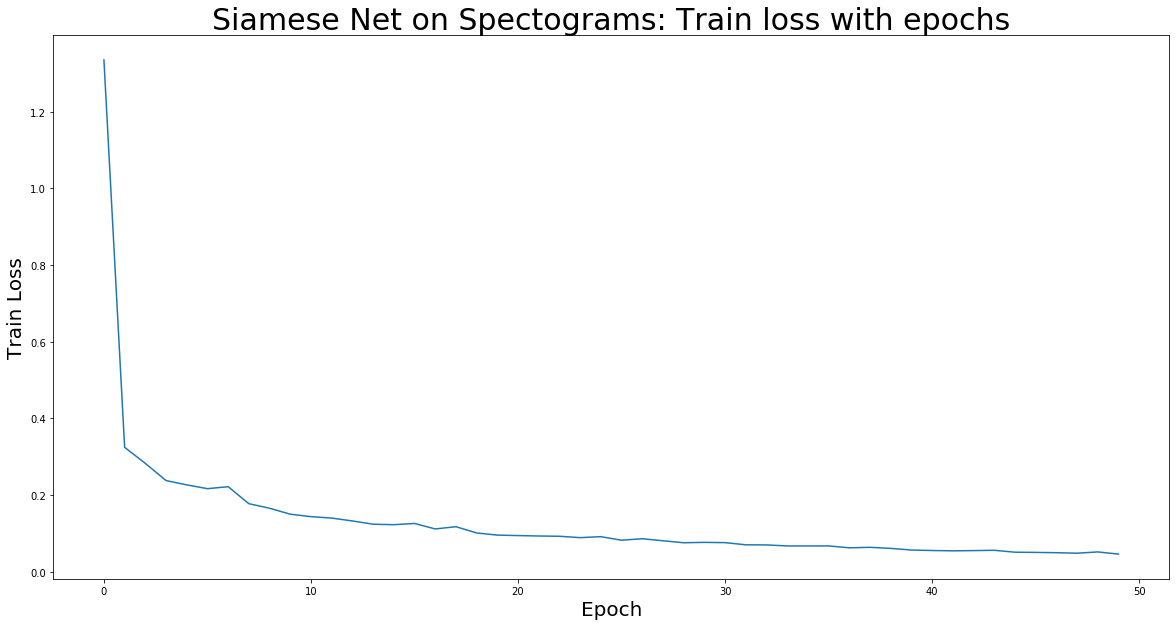

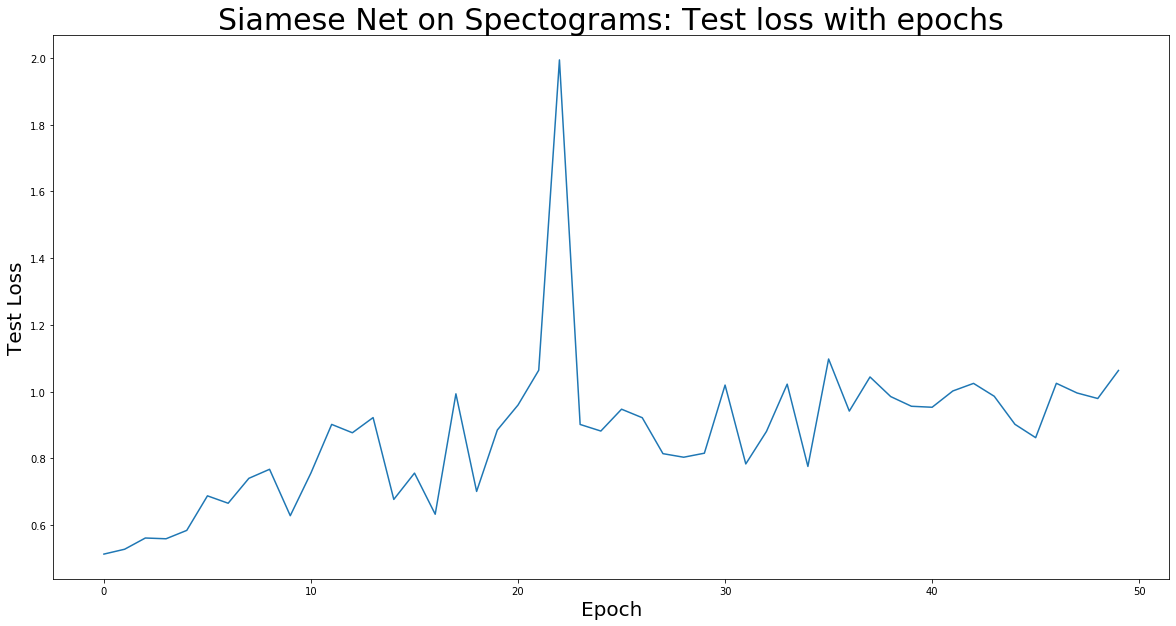

In [0]:
ep, val = zip(*train_losses)
my_plot(ep, val, 'Siamese Net on Spectograms: Train loss with epochs', 'Epoch', 'Train Loss')
ep, val = zip(*test_losses)
my_plot(ep, val, 'Siamese Net on Spectograms: Test loss with epochs', 'Epoch', 'Test Loss')

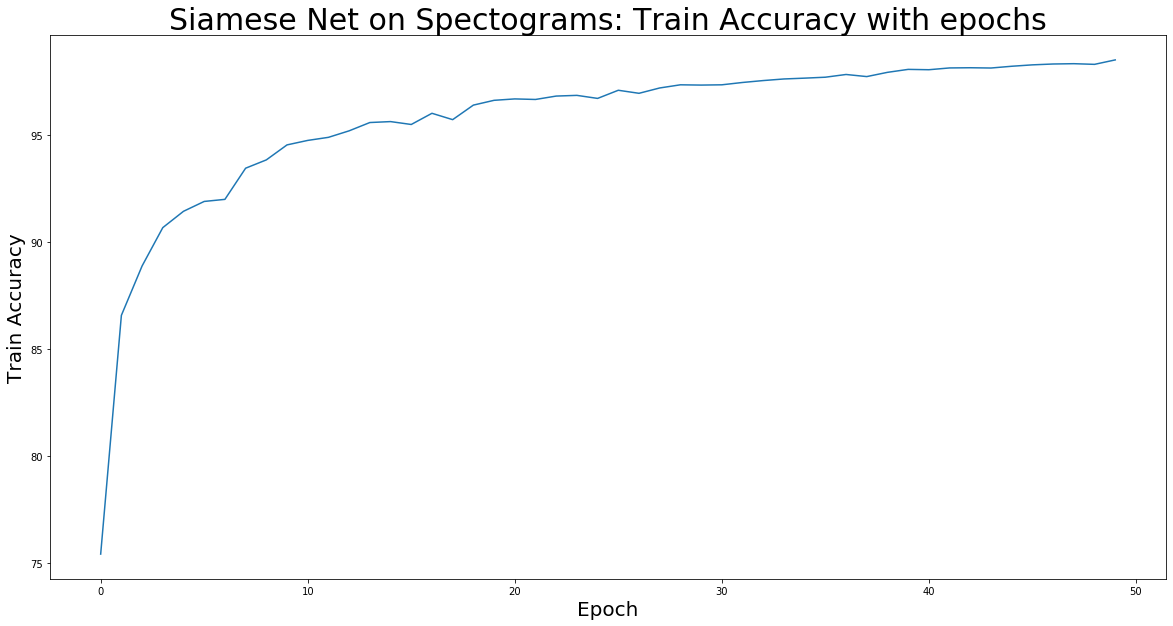

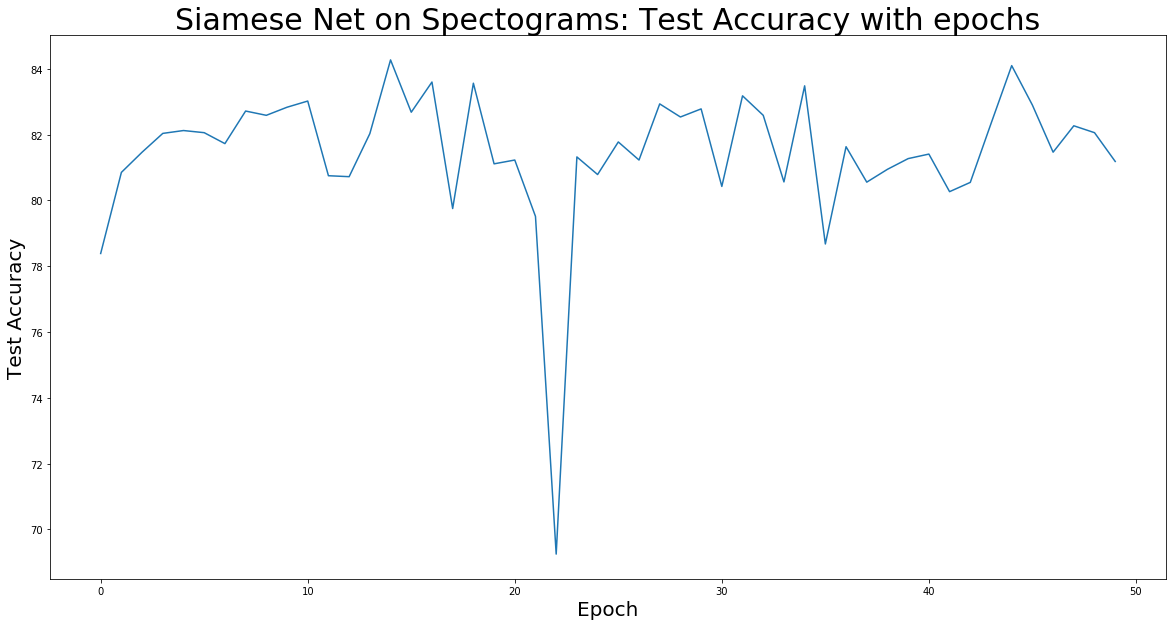

In [0]:
ep, val = zip(*train_accuracies)
my_plot(ep, val, 'Siamese Net on Spectograms: Train Accuracy with epochs', 'Epoch', 'Train Accuracy')
ep, val = zip(*test_accuracies)
my_plot(ep, val, 'Siamese Net on Spectograms: Test Accuracy with epochs', 'Epoch', 'Test Accuracy')

In [0]:
torch.save(net.state_dict(), 'siamese_net_crossEntropy.pt')

In [0]:
def restore(net, save_file):
    """Restores the weights from a saved file

    This does more than the simple Pytorch restore. It checks that the names
    of variables match, and if they don't doesn't throw a fit. It is similar
    to how Caffe acts. This is especially useful if you decide to change your
    network architecture but don't want to retrain from scratch.

    Args:
        net(torch.nn.Module): The net to restore
        save_file(str): The file path
    """

    net_state_dict = net.state_dict()
    restore_state_dict = torch.load(save_file)

    restored_var_names = set()

    print('Restoring:')
    for var_name in restore_state_dict.keys():
        if var_name in net_state_dict:
            var_size = net_state_dict[var_name].size()
            restore_size = restore_state_dict[var_name].size()
            if var_size != restore_size:
                print('Shape mismatch for var', var_name, 'expected', var_size, 'got', restore_size)
            else:
                if isinstance(net_state_dict[var_name], torch.nn.Parameter):
                    # backwards compatibility for serialized parameters
                    net_state_dict[var_name] = restore_state_dict[var_name].data
                try:
                    net_state_dict[var_name].copy_(restore_state_dict[var_name])
                    print(str(var_name) + ' -> \t' + str(var_size) + ' = ' + str(int(np.prod(var_size) * 4 / 10**6)) + 'MB')
                    restored_var_names.add(var_name)
                except Exception as ex:
                    print('While copying the parameter named {}, whose dimensions in the model are'
                          ' {} and whose dimensions in the checkpoint are {}, ...'.format(
                              var_name, var_size, restore_size))
                    raise ex

    ignored_var_names = sorted(list(set(restore_state_dict.keys()) - restored_var_names))
    unset_var_names = sorted(list(set(net_state_dict.keys()) - restored_var_names))
    print('')
    if len(ignored_var_names) == 0:
        print('Restored all variables')
    else:
        print('Did not restore:\n\t' + '\n\t'.join(ignored_var_names))
    if len(unset_var_names) == 0:
        print('No new variables')
    else:
        print('Initialized but did not modify:\n\t' + '\n\t'.join(unset_var_names))

    print('Restored %s' % save_file)

In [0]:
net_new = SiameseNetwork().to(device)

In [0]:
!ls

mfcc			     test-gram		   train-gram-100.tar.gz
siamese_net_crossEntropy.pt  test_losses.npy	   train_losses.npy
test_accuracies.npy	     train_accuracies.npy
test_gram		     train-gram


In [0]:
restore(net_new, 'siamese_net_crossEntropy.pt')

Restoring:
cnn1.1.weight -> 	torch.Size([4, 1, 3, 3]) = 0MB
cnn1.1.bias -> 	torch.Size([4]) = 0MB
cnn1.3.weight -> 	torch.Size([4]) = 0MB
cnn1.3.bias -> 	torch.Size([4]) = 0MB
cnn1.3.running_mean -> 	torch.Size([4]) = 0MB
cnn1.3.running_var -> 	torch.Size([4]) = 0MB
cnn1.3.num_batches_tracked -> 	torch.Size([]) = 0MB
cnn1.5.weight -> 	torch.Size([8, 4, 3, 3]) = 0MB
cnn1.5.bias -> 	torch.Size([8]) = 0MB
cnn1.7.weight -> 	torch.Size([8]) = 0MB
cnn1.7.bias -> 	torch.Size([8]) = 0MB
cnn1.7.running_mean -> 	torch.Size([8]) = 0MB
cnn1.7.running_var -> 	torch.Size([8]) = 0MB
cnn1.7.num_batches_tracked -> 	torch.Size([]) = 0MB
fc1.0.weight -> 	torch.Size([512, 412232]) = 844MB
fc1.0.bias -> 	torch.Size([512]) = 0MB
fc2.weight -> 	torch.Size([2, 512]) = 0MB
fc2.bias -> 	torch.Size([2]) = 0MB

Restored all variables
No new variables
Restored siamese_net_crossEntropy.pt


In [0]:
net_new

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=412232, out_features=512, bias=True)
    (1): ReLU(inplace=True)
  )
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [0]:
for epoch in range(0, 2):
    print("Epoch number: ", epoch)
    #lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
    start_time = time.time()
    print("\nTraining:")
    train_loss, train_accuracy = train(net_new, device, train_dataloader, epoch)
    print("\nTesting:")
    test_loss, test_accuracy = test(net_new, device, test_dataloader)
    #train_losses.append((epoch, train_loss))
    #test_losses.append((epoch, test_loss))
    #train_accuracies.append((epoch, train_accuracy))
    #test_accuracies.append((epoch, test_accuracy))
    #torch.save(net.state_dict(), 'siamese_net_crossEntropy.pt')
    end_time = time.time()
    print("Time taken for running epoch {} is {:.3f} seconds.\n\n".format(epoch, end_time-start_time))

  0%|          | 0/215 [00:00<?, ?it/s]

Epoch number:  0

Training:


  0%|          | 1/215 [00:05<19:41,  5.52s/it]

Train Epoch: 0 [256/54863 (0%)]	Loss: 0.081615	Train Accuracy: 96.093750


 10%|▉         | 21/215 [00:47<07:11,  2.23s/it]

Train Epoch: 0 [5376/54863 (10%)]	Loss: 0.072862	Train Accuracy: 98.325890


 19%|█▉        | 41/215 [01:28<06:06,  2.11s/it]

Train Epoch: 0 [10496/54863 (19%)]	Loss: 0.053878	Train Accuracy: 98.504189


 28%|██▊       | 61/215 [02:08<05:30,  2.15s/it]

Train Epoch: 0 [15616/54863 (28%)]	Loss: 0.051315	Train Accuracy: 98.443901


 38%|███▊      | 81/215 [02:46<04:25,  1.98s/it]

Train Epoch: 0 [20736/54863 (38%)]	Loss: 0.018463	Train Accuracy: 98.456787


 47%|████▋     | 101/215 [03:24<03:39,  1.92s/it]

Train Epoch: 0 [25856/54863 (47%)]	Loss: 0.044337	Train Accuracy: 98.456841


 56%|█████▋    | 121/215 [04:01<02:57,  1.89s/it]

Train Epoch: 0 [30976/54863 (56%)]	Loss: 0.058854	Train Accuracy: 98.440727


 66%|██████▌   | 141/215 [04:38<02:19,  1.88s/it]

Train Epoch: 0 [36096/54863 (66%)]	Loss: 0.039389	Train Accuracy: 98.431961


 75%|███████▍  | 161/215 [05:15<01:41,  1.89s/it]

Train Epoch: 0 [41216/54863 (75%)]	Loss: 0.041723	Train Accuracy: 98.454483


 84%|████████▍ | 181/215 [05:51<01:03,  1.86s/it]

Train Epoch: 0 [46336/54863 (84%)]	Loss: 0.044301	Train Accuracy: 98.459084


 93%|█████████▎| 201/215 [06:28<00:26,  1.90s/it]

Train Epoch: 0 [51456/54863 (93%)]	Loss: 0.033503	Train Accuracy: 98.486084


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0453, Train Accuracy = 98.4963


Testing:


  0%|          | 0/215 [00:00<?, ?it/s]


Test set: Average loss = 1.0785, Test Accuracy = 81.7715

Time taken for running epoch 0 is 504.530 seconds.


Epoch number:  1

Training:


  0%|          | 1/215 [00:04<17:32,  4.92s/it]

Train Epoch: 1 [256/54863 (0%)]	Loss: 0.031359	Train Accuracy: 99.218750


 10%|▉         | 21/215 [00:42<06:22,  1.97s/it]

Train Epoch: 1 [5376/54863 (10%)]	Loss: 0.051052	Train Accuracy: 98.344498


 19%|█▉        | 41/215 [01:21<05:46,  1.99s/it]

Train Epoch: 1 [10496/54863 (19%)]	Loss: 0.047540	Train Accuracy: 98.418442


 28%|██▊       | 61/215 [01:59<05:02,  1.97s/it]

Train Epoch: 1 [15616/54863 (28%)]	Loss: 0.049760	Train Accuracy: 98.431099


 38%|███▊      | 81/215 [02:36<04:21,  1.95s/it]

Train Epoch: 1 [20736/54863 (38%)]	Loss: 0.039669	Train Accuracy: 98.374809


 47%|████▋     | 101/215 [03:14<03:44,  1.97s/it]

Train Epoch: 1 [25856/54863 (47%)]	Loss: 0.047179	Train Accuracy: 98.425896


 56%|█████▋    | 121/215 [03:51<03:01,  1.93s/it]

Train Epoch: 1 [30976/54863 (56%)]	Loss: 0.068351	Train Accuracy: 98.443954


 66%|██████▌   | 141/215 [04:28<02:15,  1.83s/it]

Train Epoch: 1 [36096/54863 (66%)]	Loss: 0.031302	Train Accuracy: 98.443039


 75%|███████▍  | 161/215 [05:05<01:42,  1.90s/it]

Train Epoch: 1 [41216/54863 (75%)]	Loss: 0.078346	Train Accuracy: 98.422943


 84%|████████▍ | 181/215 [05:41<01:04,  1.88s/it]

Train Epoch: 1 [46336/54863 (84%)]	Loss: 0.037639	Train Accuracy: 98.454765


 93%|█████████▎| 201/215 [06:16<00:25,  1.82s/it]

Train Epoch: 1 [51456/54863 (93%)]	Loss: 0.042177	Train Accuracy: 98.478310


  0%|          | 0/55 [00:00<?, ?it/s]


Train set: Average loss = 0.0454, Train Accuracy = 98.4525


Testing:


100%|██████████| 55/55 [01:23<00:00,  1.52s/it]


Test set: Average loss = 1.0256, Test Accuracy = 81.7281

Time taken for running epoch 1 is 483.785 seconds.


